# Inverse problem: Biology-informed assimilation of pheromone sensors data in the pheromone propagation model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path
import os
import time

import pherosensor

from pheromone_dispersion.geom import MeshRect2D
from pheromone_dispersion.diffusion_tensor import DiffusionTensor
from pheromone_dispersion.velocity import Velocity
from pheromone_dispersion.source_term import Source
from pheromone_dispersion.convection_diffusion_2D import DiffusionConvectionReaction2DEquation

from source_localization.obs import Obs
from source_localization.control import Control
from source_localization.cost import Cost
from source_localization.population_dynamique import PopulationDynamicModel
from source_localization.adjoint_convection_diffusion_2D import AdjointDiffusionConvectionReaction2DEquation

from utils.plot_colormap import plot_colormap
from utils.plot_obs import plot_obs
from utils.plot_ctrl import plot_ctrl
from utils.plot_cost import plot_cost

/home/tmalou/anaconda3/envs/pherosensor/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
path = os.getcwd()
path_data = path + '/data'
path_output = path + '/output'
if not os.path.isdir(Path(path_output)):
    os.makedirs(Path(path_output))
path_plot = path_output + '/plot'
if not os.path.isdir(Path(path_plot)):
    os.makedirs(Path(path_plot))

This notebook aims to present the biology-informed data assimilation (BI-DA) problem solved to infer the quantity of pheromone emitted from pheromone sensors data, the solvers implemented in the module `source_localization` and the different submodules on which the solvers are based. 

In a first section, the data assimilation problem is presented.
Then, the different submodules are presented and illustrated over a simple but representative case, in line with the case used in the notebook dedicated to [modelling pheromone propagation](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/tutorials/pheromone_propagation_model.ipynb).
Finally, the numerical solvers of the BI-DA problem are presented and used to infer the quantity of pheromone emitted in different scenario of biological information addition. 

## Pheromone sensors data assimilation for the inference of the quantity of emitted pheromone

The goal of data assimilation (DA) is to estimate the quantity of pheromone emitted by the insects, also referred to as the control variable, using time-series of pheromone sensors spatially distributed over the landscape of interest.

To do so, we solve an inverse problem corresponding to the following direct problem describing pheromone propagation over the landscape (see equation (1) in the notebook [modelling pheromone propagation](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/tutorials/pheromone_propagation_model.ipynb) for details)

$$
\frac{\partial c}{\partial t}-\nabla\cdot(\mathbf{K}\nabla c)+\nabla\cdot(\vec{u}c)+\tau_{loss}c=s~\forall (x,y,t)\in\Omega\times[0;T] \quad \quad \quad \text{(1)}
$$

In this equation, the unknown is the pheromone density $c$, and $\mathbf{K}$, $\vec{u}$ and $\tau_{loss}$ are known parameters describing respectively the diffusion tensor, the advection by the wind and a deposition parameter. The term $s$ is the emission rate of pheromone, which is the target to be inferred by the inverse problem. 

The method consists in finding the quantity of pheromone emitted $s$ that enables the prediction of the pheromone propagation model (1) that predicts the closest outputs to the data.

Therefore, the DA problem is defined as a minimization problem over a cost function $j$:

$$
    \begin{cases}
        \text{find }s_a(x,y,t)\text{ such that} \\ 
        s_a(x,y,t)=\text{arg}\min_{s(x,y,t)}j(s)\text{ with } j(s)=j_{obs}(s)+j_{reg}(s)
    \end{cases}
$$

The term $j_{obs}$ aims to minimize the gap between model predictions and data. It reads 

$$
j_{obs}(s)=\|m\left(c(s)\right)-m_{obs}\|_{\mathbf{R}^{-1}}^2
$$

where $m_{obs}$ are the observations, $c(s)$ is the pheromone concentration map predicted by the pheromone propagation model (1) from the given pheromone emission $s$, $m(c)$ is the observation operator that models the observed variable from a given pheromone concentration map and $\mathbf{R}$ is the covariance operator of the observation error. The observation operator depends on the properties of the sensor. For instance, pheromone sensors commonly use a pre-concentrator that actively filters air during a time window $\delta_t$ and releases the accumulated quantity into the sensor for the measure. In this case, the observation operator is $(m(c))_{i,k}= \int_{t_{obs,k}-\delta_t}^{t_{obs,k}} c(\tau,x_{obs, i},y_{obs, i}) d\tau$ where $(x_{obs, i},y_{obs, i})$ is the position of the $i^{th}$ sensor and $t_{obs,k}$ the $k^{th}$ time of observation.

The regularization term $j_{reg}$ is commonly added in order to ensure the well-posedness of the optimization problem. In the BI-DA framework, this regularization term is based on prior biological information describing biological knowledge of the emitter insects. A short introduction of this biology-informed regularization term can be found below and a more extensive one can be found in [Malou et al (2024)](https://hal.science/hal-04572831/).

## Biology-informed regularization terms

The BI-DA framework is based on regularization terms modeling biological information that enable to drive the DA method toward an optimum $s_a$ consistent with the biological knowledge introduced in $j_{reg}$. In general terms, the regularization term reads:

$$
j_{reg} = \sum_{i \in \mathcal{L}} \alpha_{reg,i} j_{reg,i} \quad \quad \quad \quad \text{ (2)}
$$

with $\mathcal{L}$ the list of considered BI regularization terms $j_{reg,i}$ and $\alpha_{reg,i}$ the associated weight coefficient. This allows for composite regularization terms that take into account several biological informations.

Several biology-informed regularization terms are shortly presented here. 

- The Tikhonov regularization $j_{reg,T}(s)=\|s-s_b\|^2_{\mathbf{C}^{-1}}$ enables to take into account information on the insects life habits, such as their preferred habitat and insect life cycle, through $s_b$ a prior value of $s$ and $\mathbf{C}$ the background error covariance operator.
- The LASSO regularization $j_{reg,LASSO}(s)=\|s\|_{1}$ enables to select important local pheromones emissions at the beginning of the infestation, when only few insects are expected. The LASSO term enables to discard sporious emissions.
- The population dynamics informed regularization $j_{reg,PD}(s)=\|\partial_ts-\frac{\partial_tq}{q}s+q\nabla \left(\sum_i \mathcal{F}_i(s)\right)-q\sum_i\mathcal{R}_i(s)\|^2_{L^2}$  (with $q$ the quantity of pheromone emitted per insect) enables to take into account the spatio-temporal evolution of the density of insects $p=s/q$ described by the flux $F_i$ and reaction $R_i$ terms that model the behavior of the insect of interest. 

## Solving the optimization problem

To solve the minimization problem, gradient-based methods are used. Thus, at each descent step, the gradient $\nabla_sj$ must be computed and reads:

$$
\nabla_s j(s) = \nabla_s j_{obs}(s) + \nabla_s j_{reg}(s)
$$

Note that we denote $\nabla_s$ the gradient with respect to the control $s$ to avoid confusion with $\nabla$ the classical gradient with respect to the space variables. Since $s$ is defined in a high-dimensional space and $c(s)$ involves the computation of a PDE model, the numerical computation of its gradient is challenging. We use a variational method and compute the gradient by using the adjoint model of the CTM that reads:

$$
\partial_tc^* + \nabla\cdot(\mathbf{K}^T\nabla c^*)+\nabla(\vec{u}c^*)-(\nabla.\vec{u})c^*-\tau_{loss}c^* = \left(\frac{dm}{dc}(c(s))\right)^*\cdot2\mathbf{R}^{-1}\left(m(c(s))-m_{obs}\right) \quad \quad \quad \quad \text{ (3)}
$$

with $c^*$ the adjoint state.\
The adjoint model is closed by the following final and boundary conditions:

- a null final condition $c^*(x,y,t=T)=0$ $\forall (x,y)\in\Omega$,
- a null diffusive flux $\mathbf{K}^T\nabla c^*\cdot\vec{n}=0$ $\forall (x,y)\in\partial\Omega$,
- a null outgoing convective flux $\vec{u}c^*\cdot\vec{n}=0$ $\forall (x,y)\in\partial\Omega\cap \{(x,y)|\vec{u}(x,y,t)\cdot\vec{n}>0\}~\forall t\in]0;T]$ with $\vec{n}$ the outgoing normal vector.

Once the adjoint state is computed, the gradient $\nabla_s j$ is computed using the expression:

$$
    \nabla_s j(s) = \nabla_s j_{reg}(s)-c^*(s)
$$

The adjoint model is solved using an implicit downwind finite volume scheme on the same Cartesian grid as the direct problem. 
More details can be found in the notebooks located in the folder `./test_numerical_scheme/` that introduce and test the numerical scheme, including convergence, and the solvers.

# Construction of the solver of the data assimilation problem

## Specifying the geometry using the `geom` submodule 

As mentionned in the notebook on [modelling pheromone propagation](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/tutorials/pheromone_propagation_model.ipynb), for now, the numerical solver of the pheromone propagation model has been implemented for a rectangular domain $\Omega=[0;L_x]\times[0;L_y]$.
Moreover, the mesh is supposed to be cartesian (rectangular cells) with constant space steps $\Delta x$ and $\Delta y$. \
Such geometry can be generated as an object of the `MeshRect2D`class of the `geom` [submodule](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/pheromone_dispersion/geom.py).

In [3]:
Lx = 30 # the length along the x-axis
Ly = 40 # the length along the y-axis
Delta_x = 0.5 # the space step along the x-axis
Delta_y = 0.5 # the space step along the y-axis
T_final = 20 # the final time of the simulation
msh = MeshRect2D(Lx, Ly, Delta_x, Delta_y, T_final)
msh.calc_dt_implicit_solver(.1) 

## Specifying the pheromone propagation model and its solver using the `convection_diffusion_2D` submodule

The first step is specifying the pheromone propagation model using the `convection_diffusion_2D` [submodule](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/pheromone_dispersion/convection_diffusion_2D.py) of the `pheromone_propagation` module.
This requires to specify the wind velocity field, the diffusion tensor, the loss coefficient and to initialize a source term (potentially by filling it with 0 or a prior estimate).\
The reader should refer to the [dedicated tutorial notebook](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/tutorials/pheromone_propagation_model.ipynb) for detailed information on that topic.

In [4]:
U_vi = np.load(Path(path_data) / f'U_vi.npy')
U_hi = np.load(Path(path_data) / f'U_hi.npy')
U = Velocity(msh,U_vi, U_hi)

In [5]:
K = DiffusionTensor(U, 10., 10.)

In [6]:
deposition_coeff = 0.01*np.ones((msh.y.size, msh.x.size))

In [7]:
amp = 0.5
xc = 6.
yc = 6.
r = 1.5
S_value = np.zeros((msh.t_array.size, msh.y.size, msh.x.size))
xx, yy= np.meshgrid(msh.x, msh.y)
S_value[:, (xx-xc)**2 + (yy-yc)**2 < r**2] = amp
    
S_target = Source(msh, S_value, t=msh.t_array)

In [8]:
solver = 'implicit with stationnary matrix inversion'
tol = 1e-10
direct_model = DiffusionConvectionReaction2DEquation(
    U, 
    K, 
    deposition_coeff, 
    S_target, 
    msh, 
    tol_inversion=tol, 
    time_discretization=solver
)
fname = 'inv_matrix_implicit_solver'
direct_model.init_inverse_matrix(path_to_matrix=path_data, matrix_file_name=fname)

=== Load of the inverse of the matrix of the implicit part of the implicit with stationnary matrix inversion scheme ===


## Specifying the pheromone sensors data and properties using the `obs` submodule

The sensors data and the observation operator are contained in an object of the `Obs` class of the `obs` [submodule](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/source_localization/obs.py).\
The user should provide the data array, that is of shape (nb data, 1), and arrays, resp. of shape (nb data, 1) and (nb data, 2), that contains the time and location of each data. 
The user can also specify the length of the time window over which the pheromone accumulates in the pre-concentration chamber of the sensor before measuring. If this time window length is not specified, it is assumed that the observation is instantaneous .

The `Obs` class also contains useful attributes and methods for pheromone sensors data and properties.
For instance, the attribute `c_est` contains the estimate of the concentration in pheromone at the positions and times required to compute the estimate of the observed variable that is containes in the attribute `d_est`. Initially, these attributes are filled with NaN. The attribute `c_est` can be updated using the `solver_est_at_obs_times` method of the `DiffusionConvectionReaction2DEquation` class and the attribute `d_est` can be updated from the attribute `c_est` using the method `obs_operator`.

In the test case used here, the data are generated as following at random sensors location using the pheromone propagation model and the target source term introduced above.

In [9]:
if not (Path(path_data) / 'd_obs_noised.npy').exists():
    from random import choices, seed
    print("--- generating synthetic data from the target source term and random sensors location---")
    dt_sensor = 2.
    nb_sensor = 30
    seed(2)
    random_index_sensor_loc = choices(range(0, msh.x.size*msh.y.size), k=nb_sensor)
    X_sensor = np.zeros((nb_sensor, 2))
    index_sensor = 0
    for i, (xi,yi) in enumerate(zip(np.repeat(msh.x,msh.y.size),np.tile(msh.y,msh.x.size))):
        if i in random_index_sensor_loc:
            X_sensor[index_sensor,:]=[xi,yi]
            index_sensor += 1
    nb_obs_per_sensor = int(msh.T_final // dt_sensor)
    t_obs_per_sensor = np.array([dt_sensor*(i+1) for i in range(nb_obs_per_sensor)])
    X_obs = np.array([[x,y] for x,y in zip(np.tile(X_sensor[:,0],nb_obs_per_sensor),np.tile(X_sensor[:,1],nb_obs_per_sensor))])
    t_obs = np.repeat(t_obs_per_sensor, nb_sensor)
    d_obs = np.zeros_like(t_obs)
    obs_prov = Obs(t_obs, X_obs, d_obs, msh, dt_obs_operator=dt_sensor)
    direct_model.solver_est_at_obs_times(obs_prov)
    obs_prov.obs_operator()    
    noise = np.random.normal(0., 0.01*np.max(obs_prov.d_est), size=obs_prov.d_est.size)
    noise_level = msh.mass_cell * msh.dt * (noise).dot(noise)
    np.save(Path(path_data) / 't_obs.npy', obs_prov.t_obs)
    np.save(Path(path_data) / 'X_obs.npy', obs_prov.X_obs)
    np.save(Path(path_data) / 'd_obs_no_noise.npy', obs_prov.d_est)
    np.save(Path(path_data) / 'd_obs_noised.npy', obs_prov.d_est+noise)
    np.save(Path(path_data) / 'noise_level.npy', noise_level)

In [10]:
dt_sensor = 2.
t_obs = np.load(Path(path_data) / 't_obs.npy')
X_obs = np.load(Path(path_data) / 'X_obs.npy')
d_obs = np.load(Path(path_data) / 'd_obs_noised.npy')
obs = Obs(t_obs, X_obs, d_obs, msh, dt_obs_operator=dt_sensor)

noise_level = np.load(Path(path_data) / 'noise_level.npy')
print("||epsilon||_2^2 = ", noise_level) 

||epsilon||_2^2 =  6.1122119221694315e-06


Moreover, the data can be plotted at a given time using the `plot_obs` [method](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/utils/plot_obs.py) of the `utils` submodule.

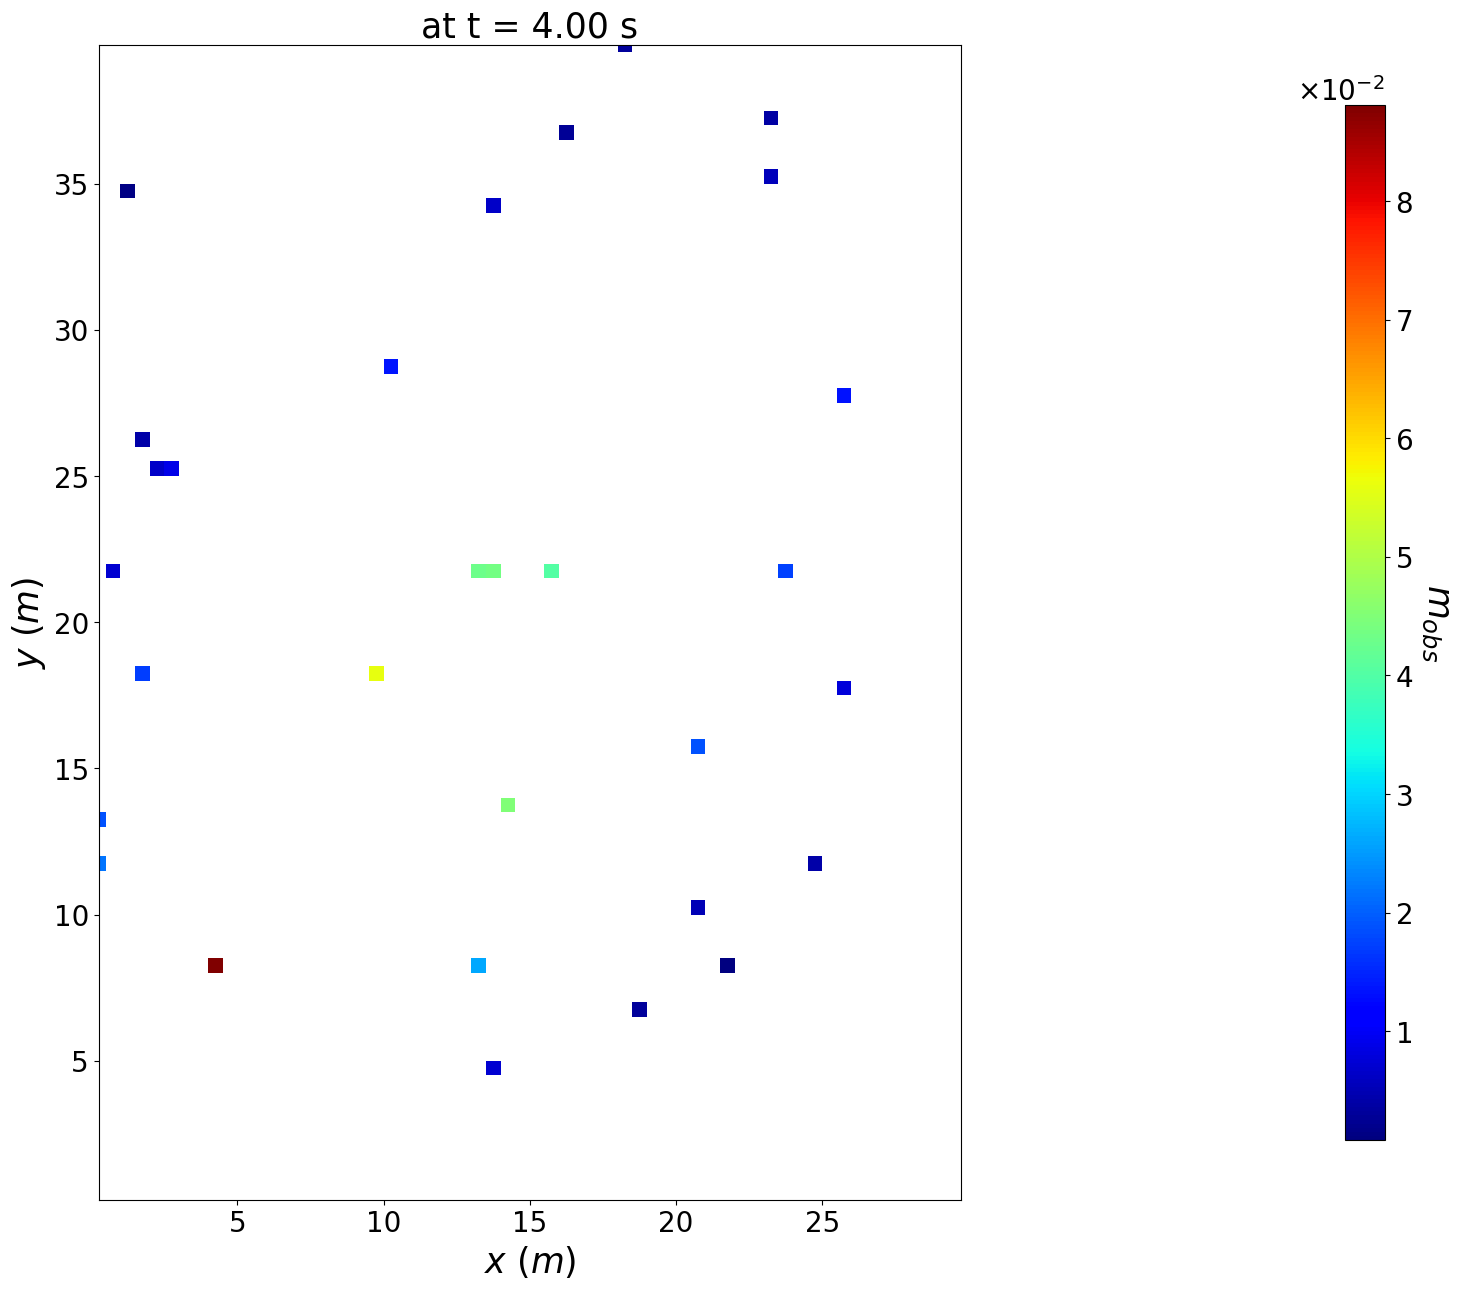

In [11]:
plot_obs(msh, t_obs[50], obs, figsize=(20, 15))

The `Obs` class also contains the method `adjoint_derivative_obs_operator` that computes the spatial map of $(d_cm)^*\cdot\delta c$, i.e. the adjoint of the derivative of the observation operator with respect to the state variable evaluated along $\delta c$ at a given time. This method is needed to compute the source function of the adjoint model (see eq. (3) ).

It also contains the method `onesensor_adjoint_derivative_obs_operator` that is similar to the `adjoint_derivative_obs_operator` method but for the one-sensor observation operator, i.e. the observation operator obtained with only one sensor, and that can be used to compute the one-sensor-adjoint state. 

The `Obs` class also have the attribute `R_inv` that contains $\mathbf{R}^{-1}$, the inverse of the observation error covariance error. In the absence of dedicated data, this attribute is set to the identity matrix. However, it will be possible in the future to specify this covariance matrix. 

## Specifying the control variable and some prior knowledge about it using the `control` submodule

The control variable to be optimized (the quantity of emitted pheromones) and all the tools to model prior knowledge about it are contained in the `control` [submodule](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/source_localization/control.py).

The user should provide an object of the class `Source` that will be used as background/prior value of the control. When initialized, the control value is set to 0. 

In [12]:
amp = 0.5
xc = 10.
yc = 10.
c = 10.
S_value_prior = np.zeros((msh.t_array.size, msh.y.size, msh.x.size))
xx, yy= np.meshgrid(msh.x, msh.y)
S_value_prior[:, np.maximum(np.abs(xx-xc), np.abs(yy-yc) ) < c] = amp
    
S_prior = Source(msh, S_value_prior, t=msh.t_array)

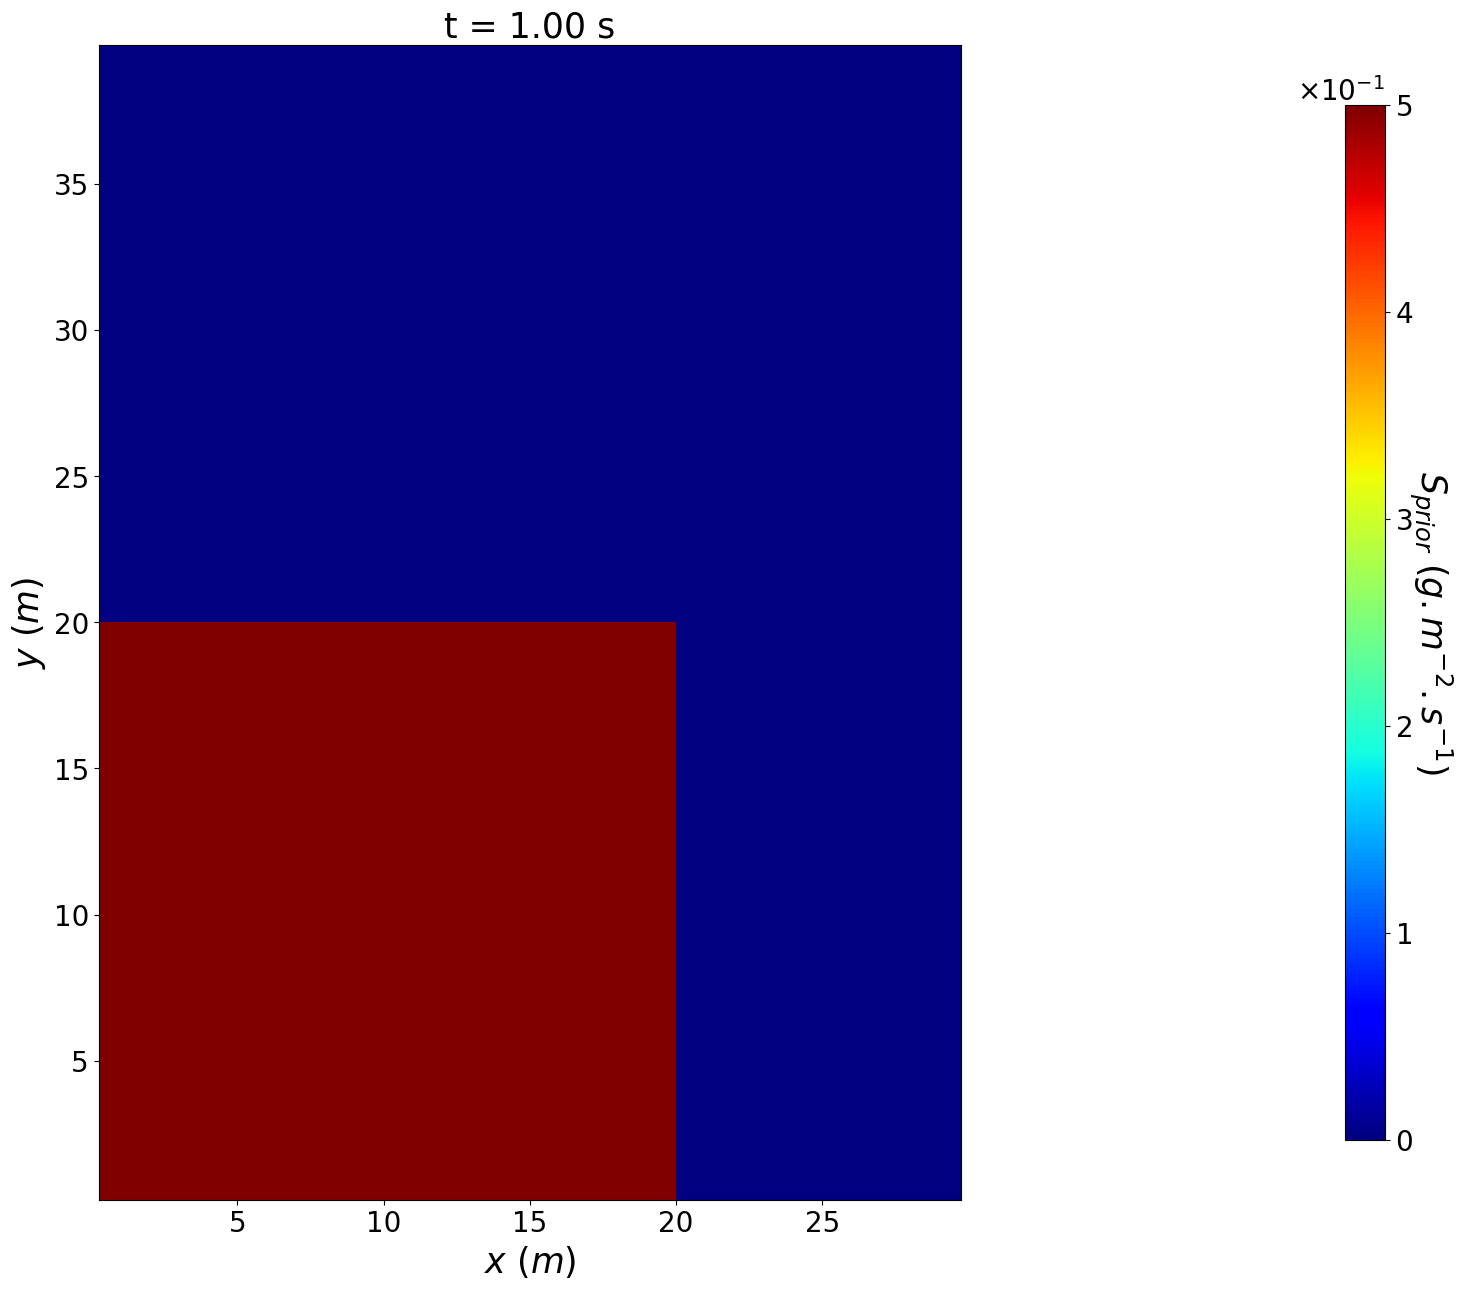

In [13]:
t_on = 1.
S_prior.at_current_time(t_on)
plot_colormap(msh,S_prior.value,'S_{prior}', 'g.m^{-2}.s^{-1}', cmap="jet",title=f't = {"{:.2f}".format(t_on)} s')

The user can include more prior knowledge of the control variable such as the population dynamic model. 
In such case, the user should specify the matrix or linear operator (by means of its matrix-vector product and of its transpose matrix-vector product) used to compute the residual of the population dynamic model. 

Up to now, the [submodule](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/source_localization/population_dynamique.py) `population_dynamic` contains a stationnary population dynamique model $\partial_t p = 0$ and a population dynamique model with linear reaction term $\partial_t p = \gamma p$ modelling that a given proportion $\gamma$ of the population stops to emit pheromone at each time step. The user can also easily specify its own population dynamic model using the different differential operators included in the toolbox (see [the different notebooks to use differential operators](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/tutorials/test_numerical_scheme/)). 

In the following, for sake of simplicity, a population dynamic model with linear reaction term is used with a null reaction term, which is then equivalent to a stationary population dynamic.

In [14]:
death_rate = np.zeros((msh.t_array.size, msh.y.size, msh.x.size))
population_dynamic_model = PopulationDynamicModel(msh, death_rate=death_rate)

In [15]:
ctrl = Control(S_prior, msh, population_dynamique_model=population_dynamic_model)

For sake of illustration, the target source term that has been used to generate the data is stored in a dedicated object of the `Control`class.

In [16]:
ctrl_target = Control(S_target, msh)
ctrl_target.value = ctrl_target.background_value 

## Specifying the adjoint model and its solver using the `adjoint_convection_diffusion_2D` submodule

The adjoint model and its solver are here contained in the `AdjointDiffusionConvectionReaction2DEquation` class of the [submodule](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/source_localization/adjoint_convection_diffusion_2D.py) `adjoint_convection_diffusion_2D`.

Similarly to the direct model, building an object of this class requires to specify the wind velocity field, the diffusion tensor and the loss coefficient.

In [17]:
solver = 'implicit with stationnary matrix inversion'
tol = 1e-10
adjoint_model =  AdjointDiffusionConvectionReaction2DEquation(U, K, deposition_coeff, msh, tol_inversion=tol, time_discretization=solver)
fname = 'inv_matrix_implicit_solver.npy'
adjoint_model.init_inverse_matrix(path_to_matrix=path_data, matrix_file_name=fname)

=== Load of the inverse of the matrix of the implicit part of the implicit with stationnary matrix inversion scheme ===


A special care has been put on the time discretization so that the discretized adjoint problem is effectively the adjoint (i.e. the matrix transposition) of the discretized direct problem. 

The reader can find more details in the notebooks located in the folder `./test_numerical_scheme/` that introduces and test the numerical schemes and their convergence. These notebooks also include test of the [adjoint operators](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/tutorials/test_numerical_scheme/test_adjoint.ipynb) and of the [gradient](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/tutorials/test_numerical_scheme/test_gradient.ipynb).

## Specifying the cost function using the `cost` submodule

The cost function, its different terms and its gradient are contained in the `Cost` class of the `cost` [submodule](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/source_localization/cost.py). 
The user should provide an object of the class `Obs` that will be used to compute the observation term of the cost function, and an object of the class `Control` that will be used to compute the regularization terms based on biological prior knowledge on the control variable and updated during the optimization process

In [18]:
cost = Cost(msh, obs, ctrl)

The class `Cost` contains several useful attributes and methods that will be presented below. 
This class contains the attribute `j_obs` that is the observation term of the cost function, the attribute `j_reg` that is the dictionnary containing the different regularization terms, the attribute `alpha` that is the dictionnary of weight coefficient of the different regularization terms (see eq. (2)). 
The attribute `implemented_regularization_types` contains the list of keywords of the implemented regularization terms. The keywords of the attributes `j_reg` and `alpha` corresponds to keywords present in the attribute `implemented_regularization_types`. 

In [19]:
print(cost.implemented_regularization_types)

['Tikhonov', 'Population dynamic', 'LASSO', 'time group LASSO', 'logarithm barrier']


The list of keyword of regularization terms to be considered and the associated dictionnary of weight coefficient can be provided as input of the instanciation of the class `Cost` or can be added and modified afterwards as in the following. If no regularization terms and its weigth coefficient are specified, than the inference will be made without regularization terms by default.

The class `Cost` also contains the methods `obs_cost` and `reg_cost` that computes resp. the observation and regularization terms and store the result in the associated attribute, as well as a method `cost_and_gradient` that brings together several methods and returns the evaluation of the cost function and its gradient from an array of shape (nb time point * nb cell in y axis * nb cell in x axis, 1) containing a quantity of pheromone emitted. 

# Inference of the quantity of emitted pheromones 

The inference is performed using the `minimize` method of the class `Cost`. 
This method takes as inputs: 

- the direct model that has been instanciated previously,
- the adjoint model that has been instanciated previously,
- the keyword of the optimization algorithm (see below).
  
The user can also provide the following optional intputs.

- The input `options` is the dictionnary of optional inputs of the optimization algorithm, such as tolerance of the termination criteria, the maximal number of iteration or the step size of the gradient descent.
- The input `path_save` is the string of the path to the folder in which the outputs will be saved. If not specified, the results of the optimization will not be save, just returned as outputs of the method.
- The input `j_obs_threshold` is the value of the threshold of the observation term of the cost function under which the optimization algorithm is stopped. This is particularly useful when some properties of the observation error are known and that we want to satisfy the Morozov's principle. For instance, one do not want the observation term of the cost function to be less than the square of the norm of the noise. 
- The input `s_init` enables to specify the initial value of the control variable. If not, the initial value is 0.
- The input `restart_flag` is a boolean flag that is False by default. It the flag is True, then the algorithm will load the outputs that has been previously saved in the folder given by the input `path_save` and start again where the algorithm stopped.

When the optimization algorithm reached the termination criteria, the method `minimize` returns: 

- the direct model with the quantity of pheromone emitted resulting from the optimization algorithm as source term,
- the array containing the observation term of the cost function at each iteration of the optimization algorithm,
- the dictionnary containing the arrays containg the regularization terms of the cost function at each iteration of the optimization algorithm,
- the array containg the resulting quantity of pheromone emitted.

When the input `path_save` is specified, in addition to the outputs detailled above, the method saves: 

- the weight coefficients of each regularization terms, in order to keep track of the test case,
- the array containg the resulting quantity of pheromone emitted in a file which name includes the number of the last iteration, to keep track of the different runs in case of restart,
- the array containing the step size at each iteration of the optimization algorithm, to keep track of the different runs in case of restart,
- the sum of the step size over the iterations of the optimization algorithm and the trajectory integrated quantity of pheromone emitted, to compute the trajectory-integrated one-sensor adjoint states. (*This feature will be improved in a future update of the module*).

## Inference without regularization

In a first time, the inference is illustrated without regularization. In this situation, the user should use a differentiable optimization algorithm such as the gradient descent algorithm. This algorithm has been implemented in the [submodule](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/source_localization/gradient_descent.py) `gradient_descent`. 

*Warning: the values of hyperparameter used here, especially the values of the step size and the maximal number of iterations, are not ideal and more attention should be given in real cases but they allow fast computations and illustrative results in this notebook.* 

In [23]:
options = {
    "nit_max": 50, 
    "step size": 5. * 1.0e+1
} 

In [24]:
direct_model_no_reg, j_obs_no_reg, _, norm_grad_j_no_reg, S_a_no_reg = cost.minimize(
    direct_model,
    adjoint_model,
    "gradient descent", 
    options=options,
    path_save=path_output,
    j_obs_threshold = noise_level
)

initialization of the optimization process, computing the initial cost
Optimizing using the gradient descent algorithm 
iteration 1: j = 8.013552e-03, j_obs = 8.013552e-03, ite comp time = 1.248e+00s -
iteration 2: j = 1.689399e-03, j_obs = 1.689399e-03, ite comp time = 2.435e+00s -
iteration 3: j = 1.133879e-03, j_obs = 1.133879e-03, ite comp time = 2.372e+00s -
iteration 4: j = 8.865612e-04, j_obs = 8.865612e-04, ite comp time = 2.434e+00s -
iteration 5: j = 7.396132e-04, j_obs = 7.396132e-04, ite comp time = 2.412e+00s -
iteration 6: j = 6.395291e-04, j_obs = 6.395291e-04, ite comp time = 2.431e+00s -
iteration 7: j = 5.650399e-04, j_obs = 5.650399e-04, ite comp time = 2.380e+00s -
iteration 8: j = 5.061600e-04, j_obs = 5.061600e-04, ite comp time = 2.364e+00s -
iteration 9: j = 4.576350e-04, j_obs = 4.576350e-04, ite comp time = 2.357e+00s -
iteration 10: j = 4.164616e-04, j_obs = 4.164616e-04, ite comp time = 2.349e+00s -
iteration 11: j = 3.808051e-04, j_obs = 3.808051e-04, ite c

The resulting optimal value of the quantity of emitted pheromones can be plotted at the a given time using the `plot_ctrl` [method](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/utils/plot_ctrl.py) of the `utils` module. The cost function and its different terms can also be plotted using the `plot_cost` [method](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/utils/plot_cost.py) of the same module (the empty inputs correspond to the regularization terms, see below).

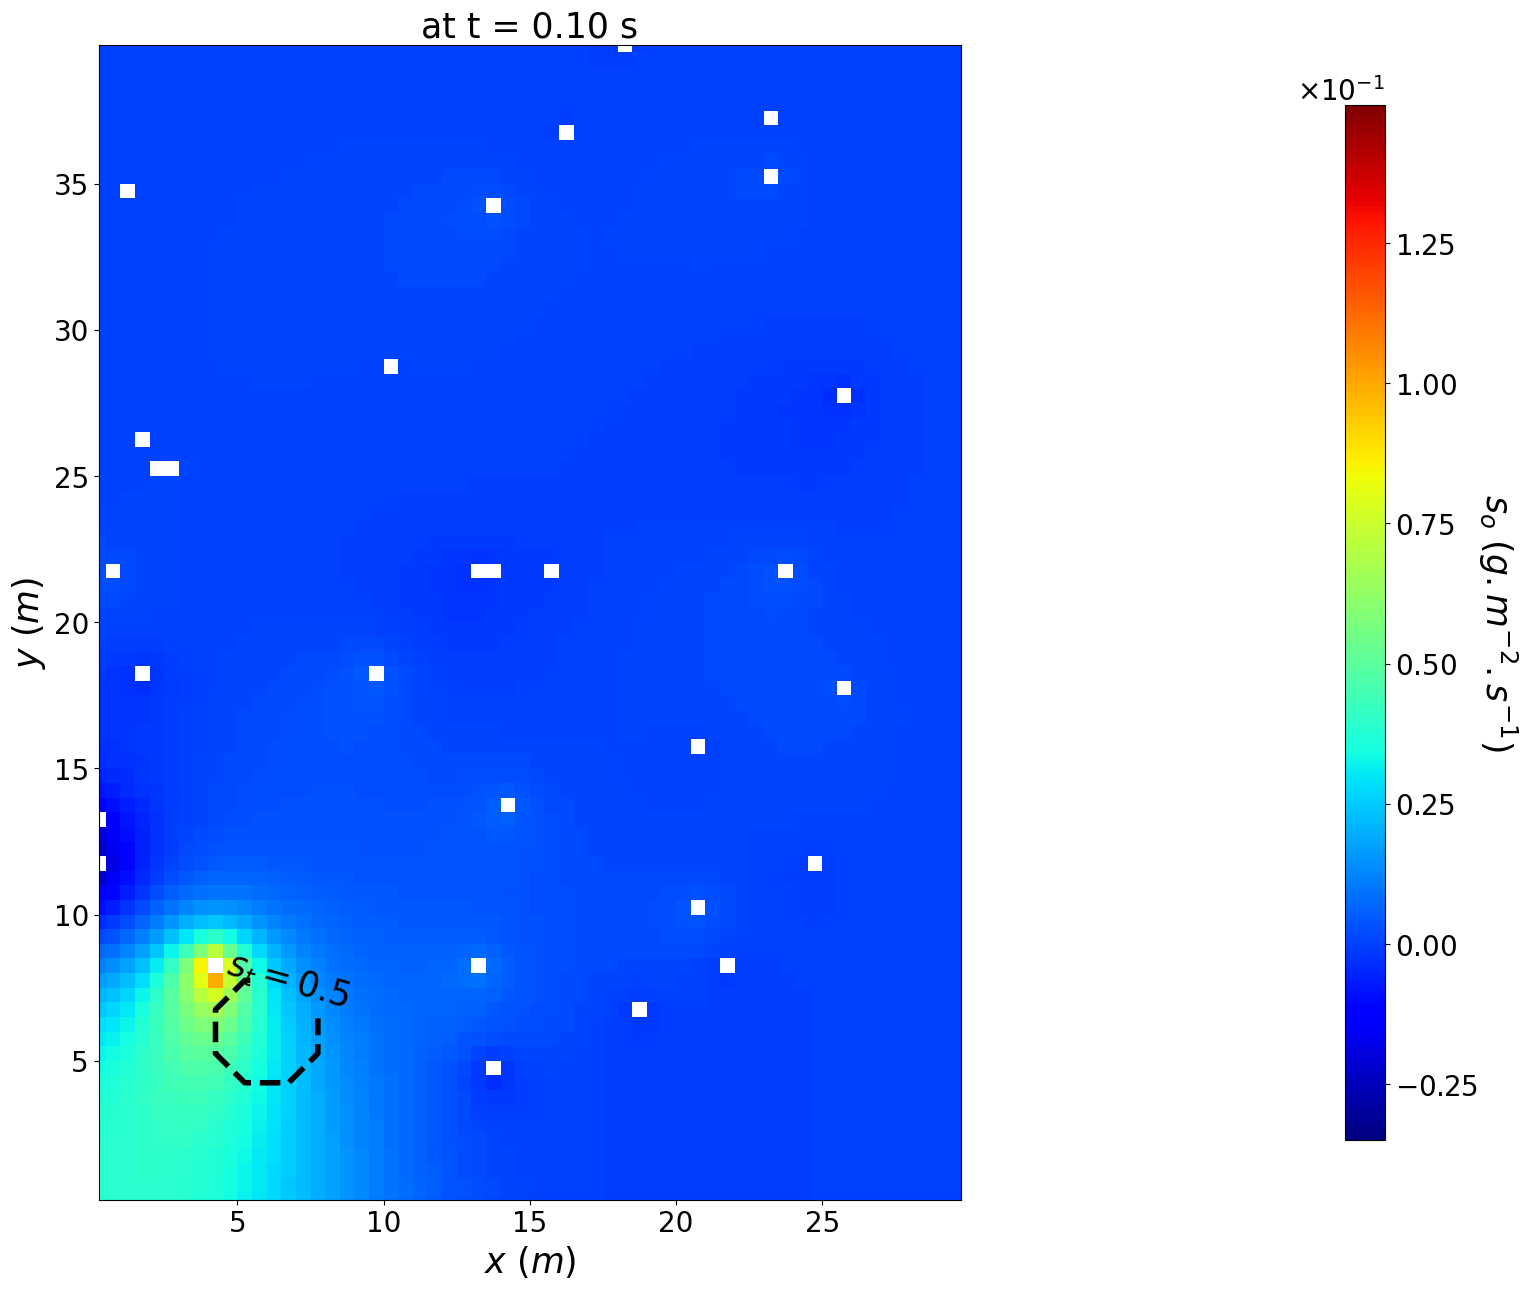

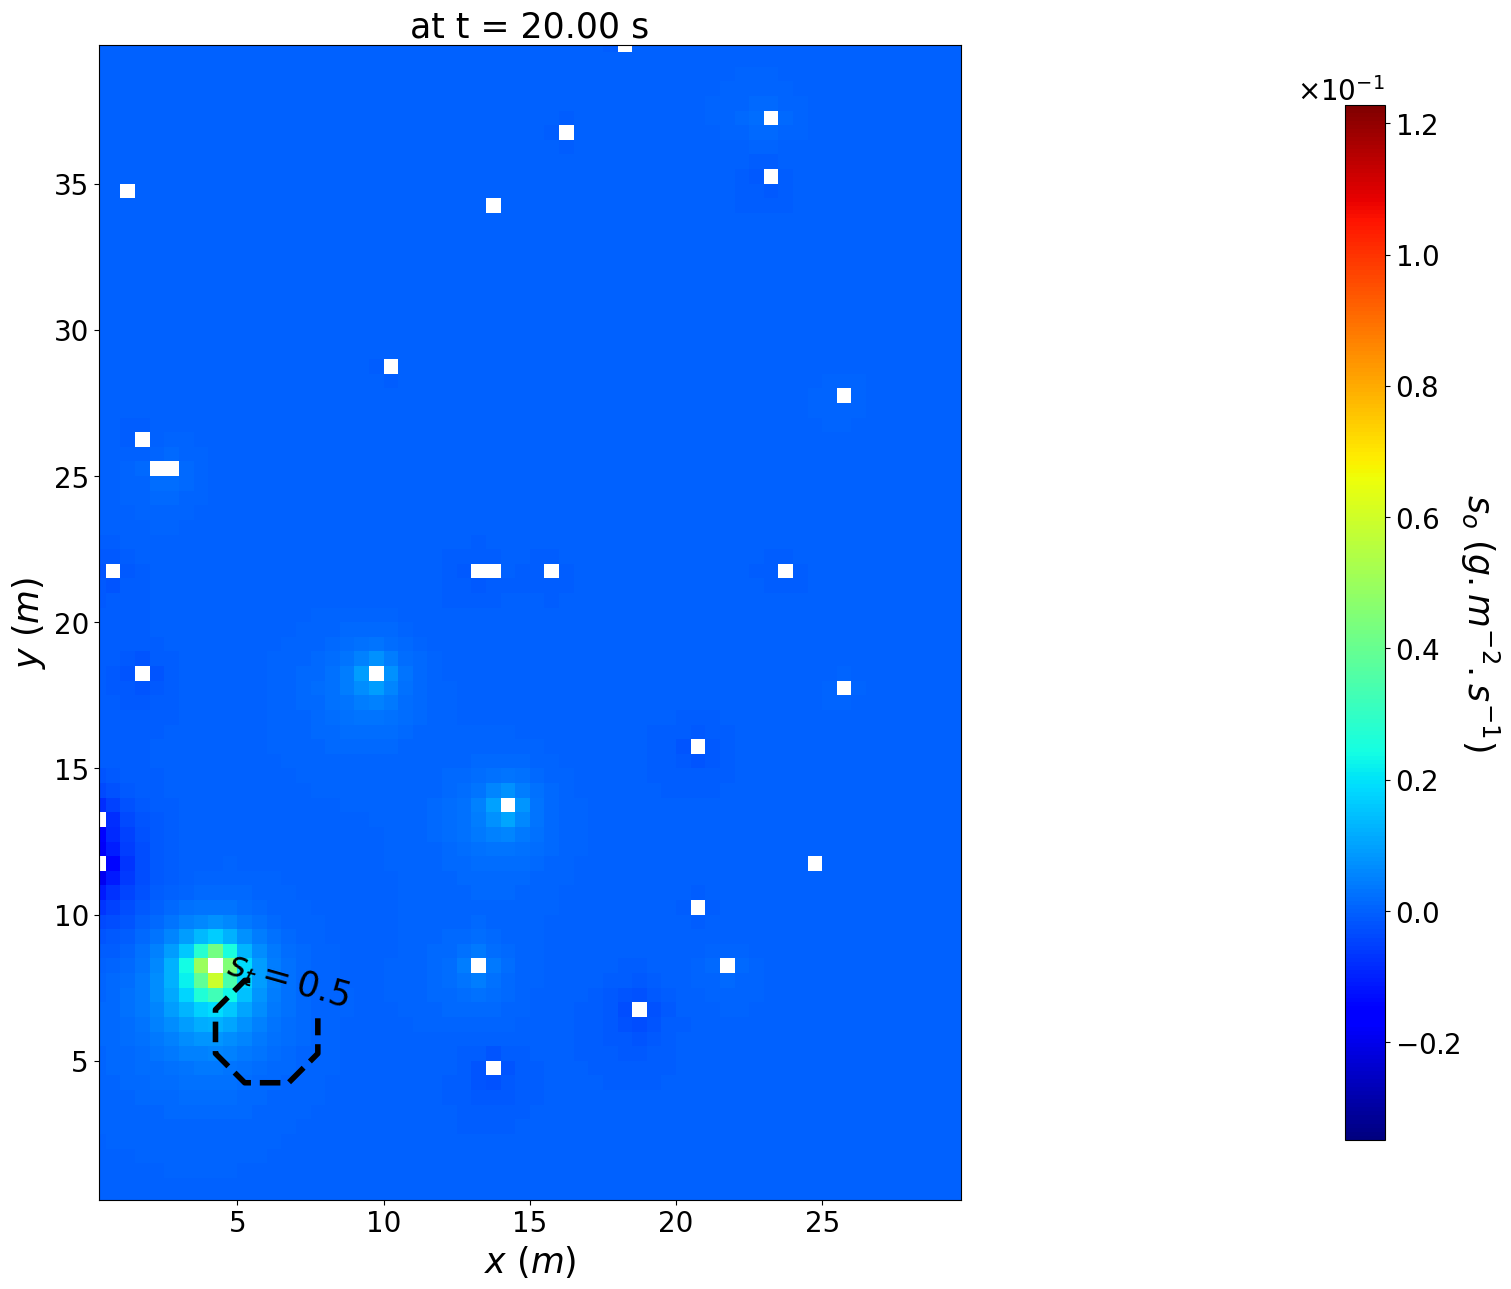

In [25]:
plot_ctrl(
    msh,
    msh.t_array[1],
    cost.ctrl,
    ctrl_target=ctrl_target.value,
    cmap="jet",
    label='s_o',
    obs=cost.obs,
    figsize=(20, 15)
)
plot_ctrl(
    msh,
    msh.t_array[-1],
    cost.ctrl,
    ctrl_target=ctrl_target.value,
    cmap="jet",
    label='s_o',
    obs=cost.obs,
    figsize=(20, 15)
)

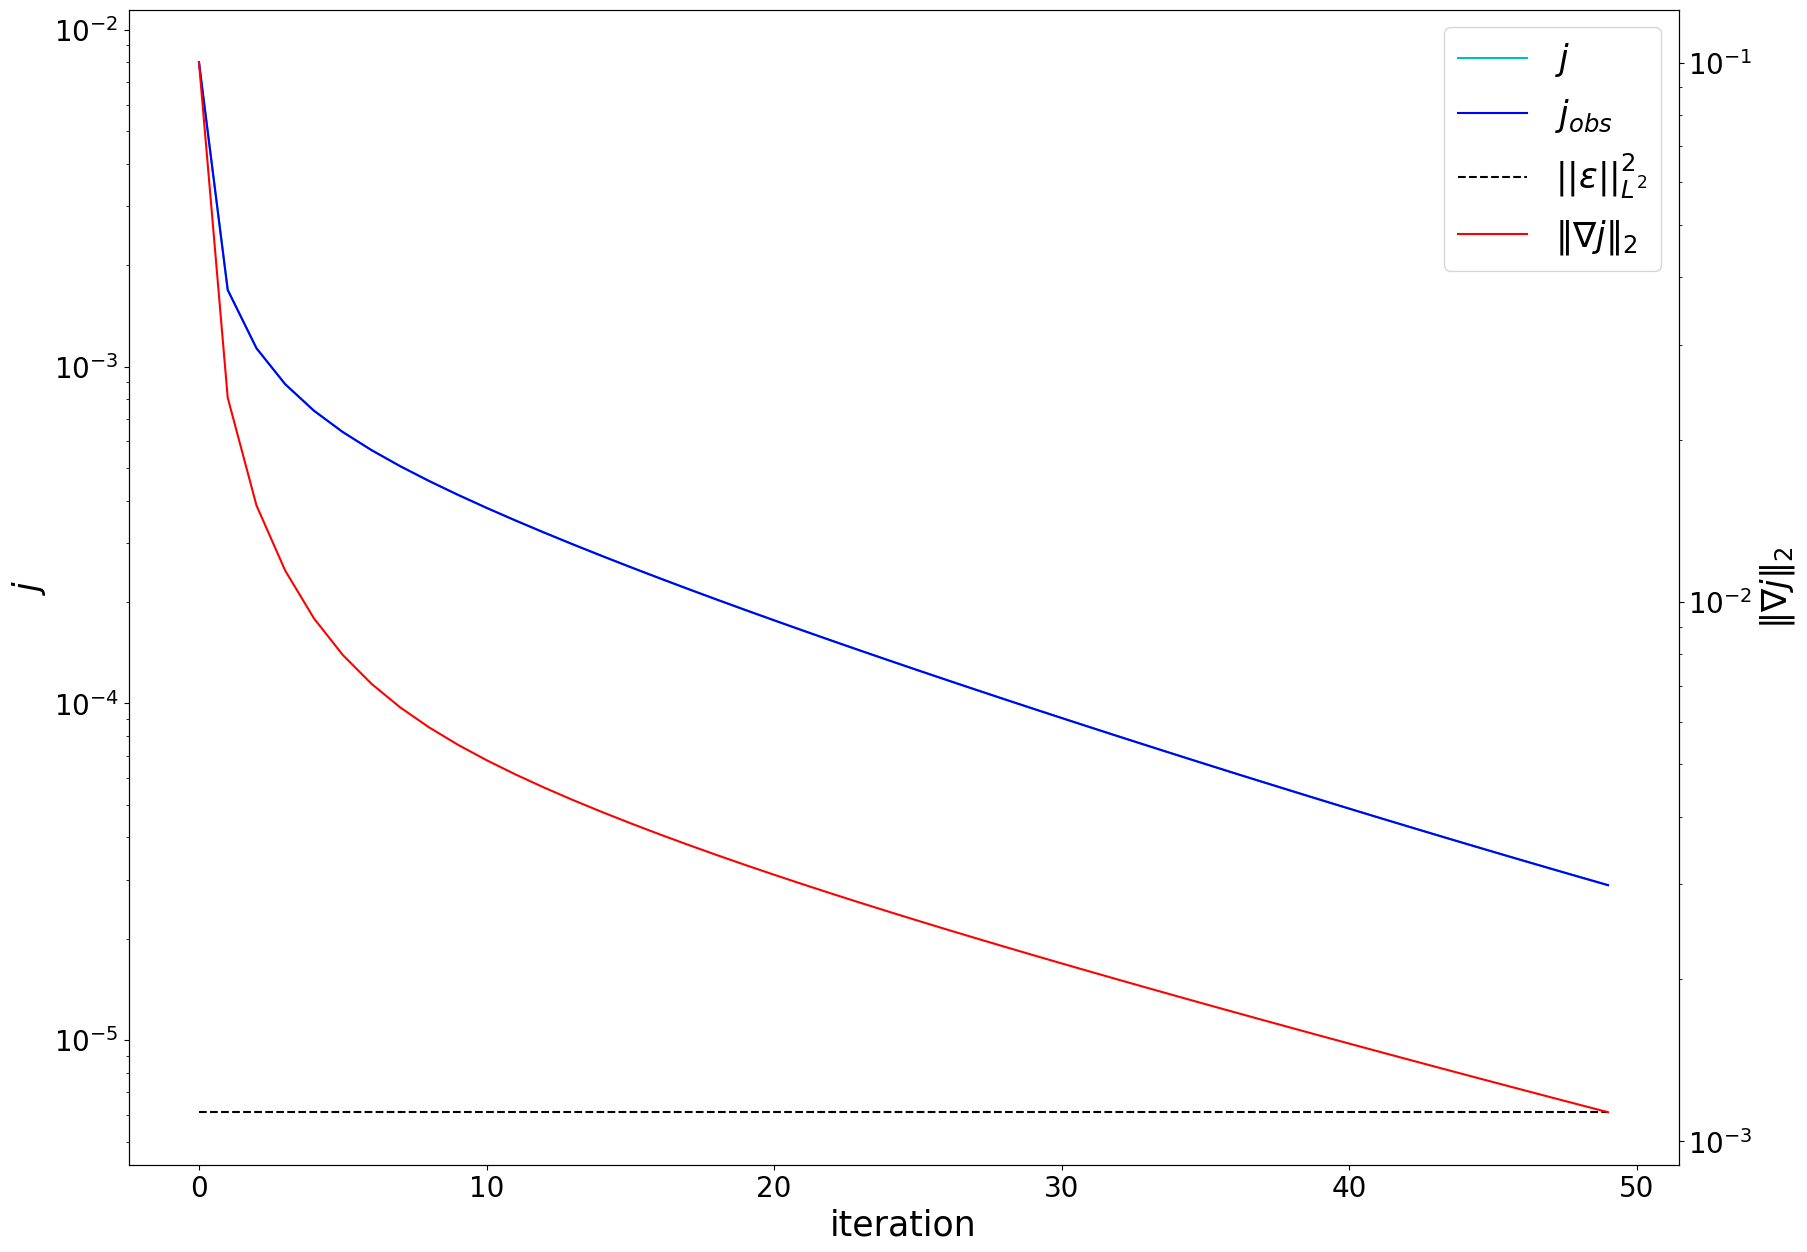

In [26]:
plot_cost(
    j_obs_no_reg, 
    {}, 
    noise_level, 
    {}, 
    {}, 
    grad_j = norm_grad_j_no_reg,
    figsize=(20, 15)
)

## Inference with a population dynamic-informed regularization term

Now, the inference is illustrated with the population dynamic-informed regularization.

One can add a regularization term to the cost function by using the `add_reg` method of the object of the class `Cost`. It takes as input the keyword of the regularization term and the value of the weight coefficient associated. If the regularization term is already in the cost function, this method will only update the value of the weight coefficient.  

In [27]:
cost.add_reg("Population dynamic", 5. * 1e-2)

As the population dynamic-informed regularization term is differentiable, the gradient descent algorithm is used. 

One may want to start from where the optimization stopped in the case without regularization (which is referred to as "hot start" in the litterature). To do so, the input 'restart_flag` is set to True. 

In [28]:
options = { 
    "nit_max": 100, 
    "step size": 5 * 1.0e-2
} 

In [29]:
direct_model_pop_dyn_reg, j_obs_pop_dyn_reg, j_reg_pop_dyn_reg, norm_grad_j_pop_dyn_reg, S_a_pop_dyn_reg = cost.minimize(
    direct_model,
    adjoint_model,
    "gradient descent", 
    options=options,
    path_save=path_output,
    restart_flag=True,
    j_obs_threshold = noise_level
)

restarting the optimization process from the data contained in the dir /home/tmalou/Documents/pherosensor/pherosensor-toolbox/tutorials/output
Optimizing using the gradient descent algorithm 
iteration 51: j = 1.135295e-02, j_obs = 2.729282e-05, ite comp time = 3.003e+00s -
iteration 52: j = 6.649820e-03, j_obs = 2.751712e-05, ite comp time = 3.467e+00s -
iteration 53: j = 5.462130e-03, j_obs = 2.757233e-05, ite comp time = 3.308e+00s -
iteration 54: j = 4.832619e-03, j_obs = 2.766869e-05, ite comp time = 3.378e+00s -
iteration 55: j = 4.412071e-03, j_obs = 2.771764e-05, ite comp time = 3.268e+00s -
iteration 56: j = 4.098070e-03, j_obs = 2.778982e-05, ite comp time = 3.309e+00s -
iteration 57: j = 3.848028e-03, j_obs = 2.783607e-05, ite comp time = 3.303e+00s -
iteration 58: j = 3.640489e-03, j_obs = 2.789859e-05, ite comp time = 3.269e+00s -
iteration 59: j = 3.463175e-03, j_obs = 2.794346e-05, ite comp time = 2.961e+00s -
iteration 60: j = 3.308450e-03, j_obs = 2.800101e-05, ite com

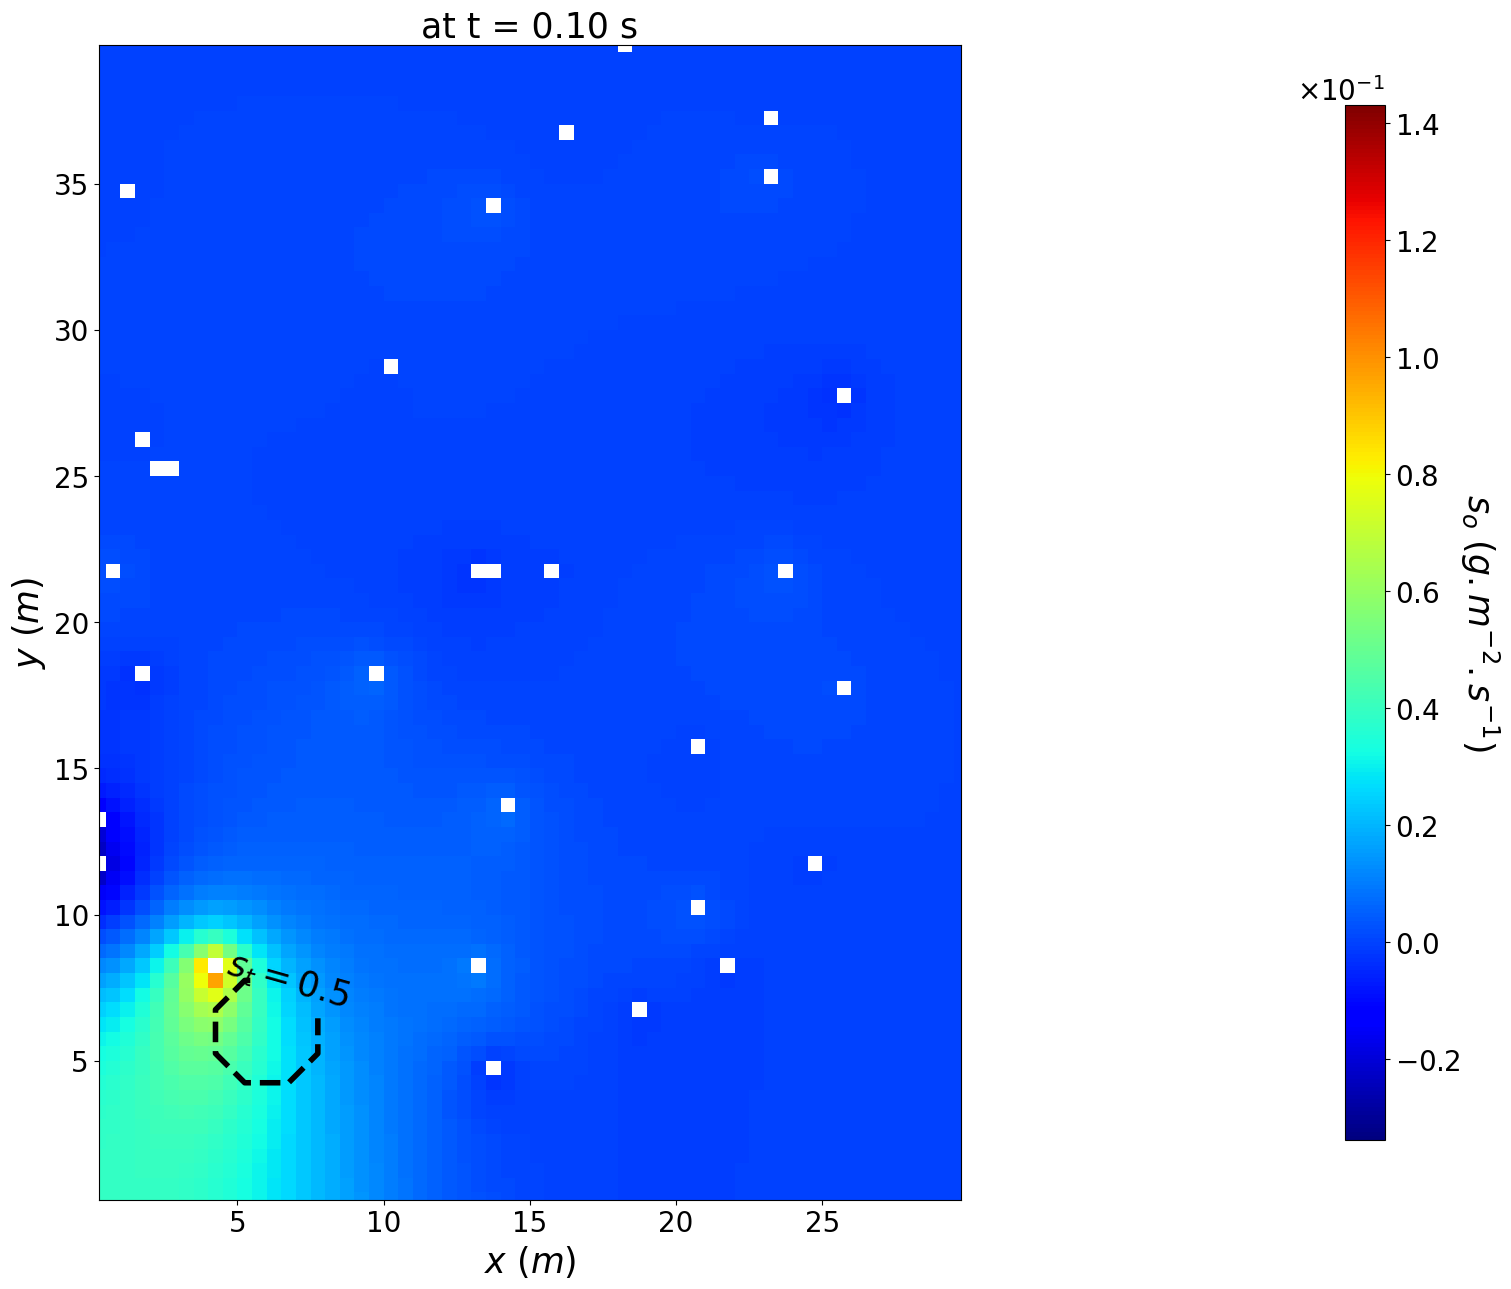

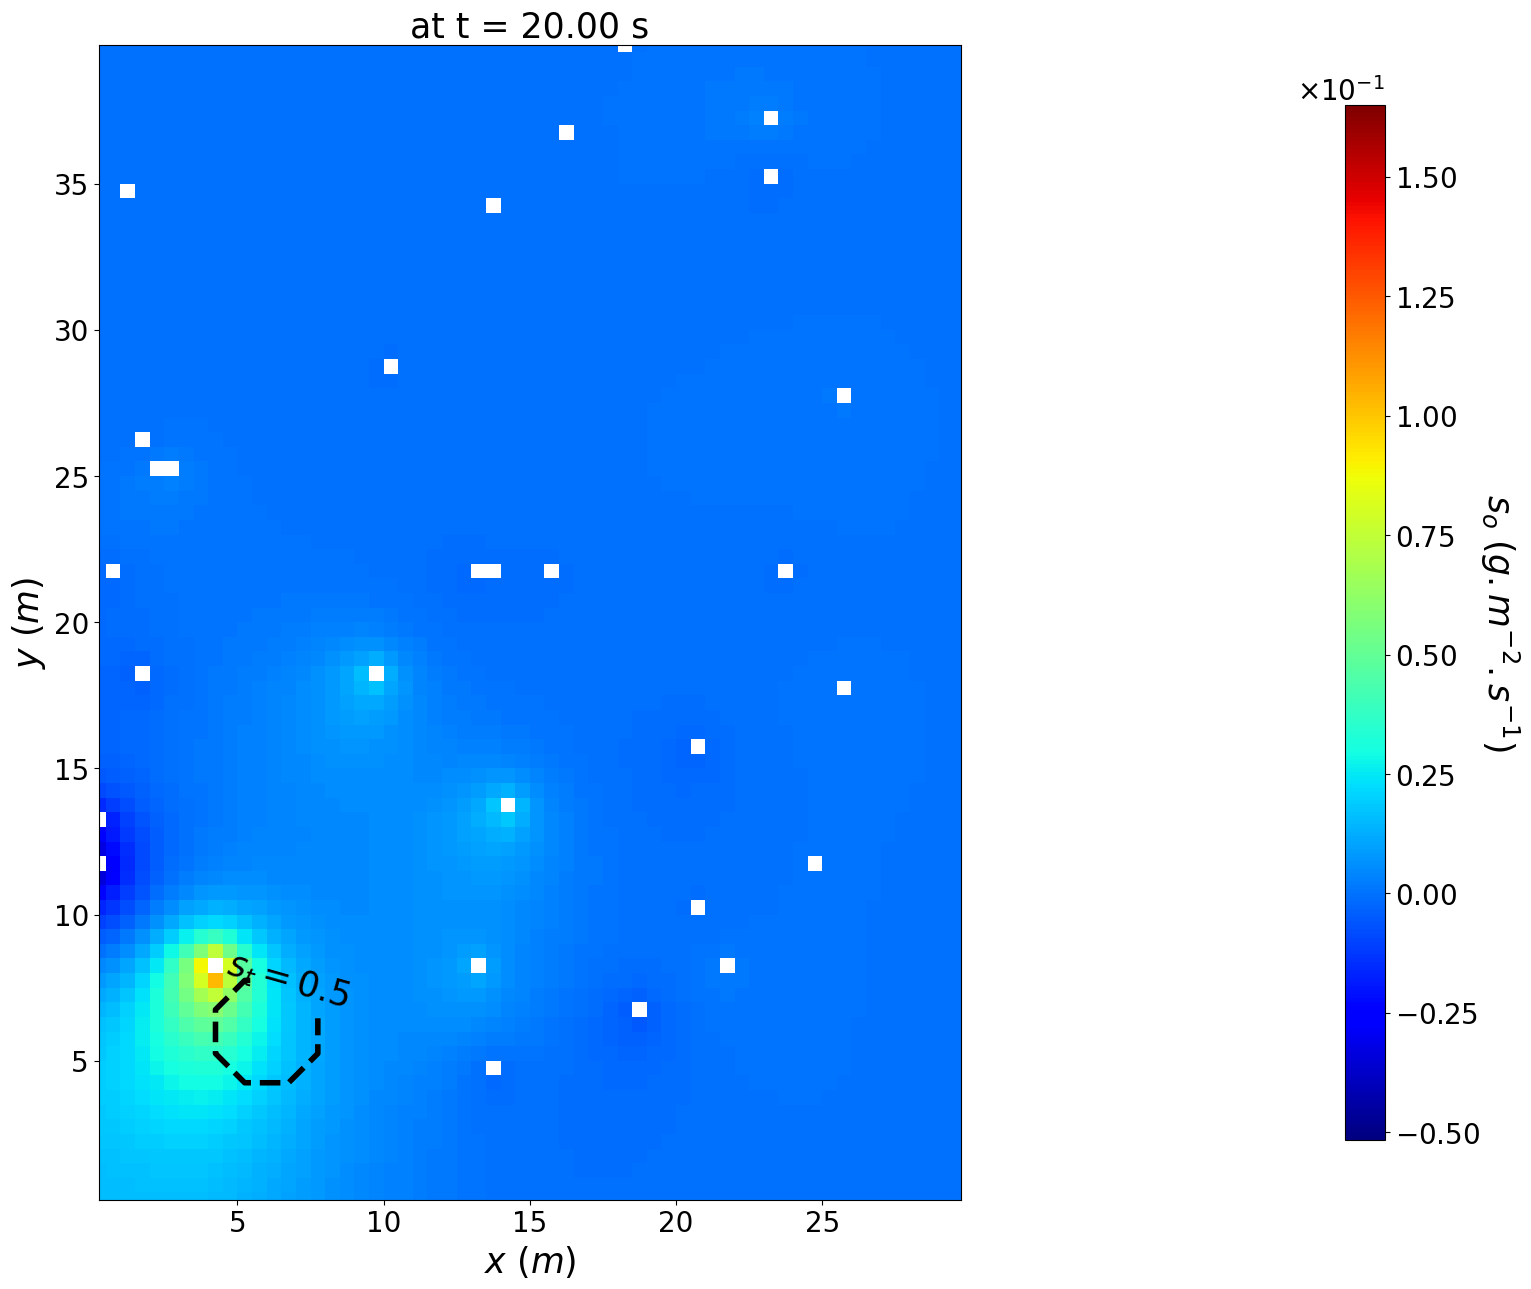

In [30]:
ctrl_pop_dyn_reg = Control(direct_model_pop_dyn_reg.S, msh)
ctrl_pop_dyn_reg.value = ctrl_pop_dyn_reg.background_value

plot_ctrl(
    msh,
    msh.t_array[1],
    ctrl_pop_dyn_reg,
    ctrl_target=ctrl_target.value,
    cmap="jet",
    label='s_o',
    obs=cost.obs,
    figsize=(20, 15)
)
plot_ctrl(
    msh,
    msh.t_array[-1],
    ctrl_pop_dyn_reg,
    ctrl_target=ctrl_target.value,
    cmap="jet",
    label='s_o',
    obs=cost.obs,
    figsize=(20, 15)
)

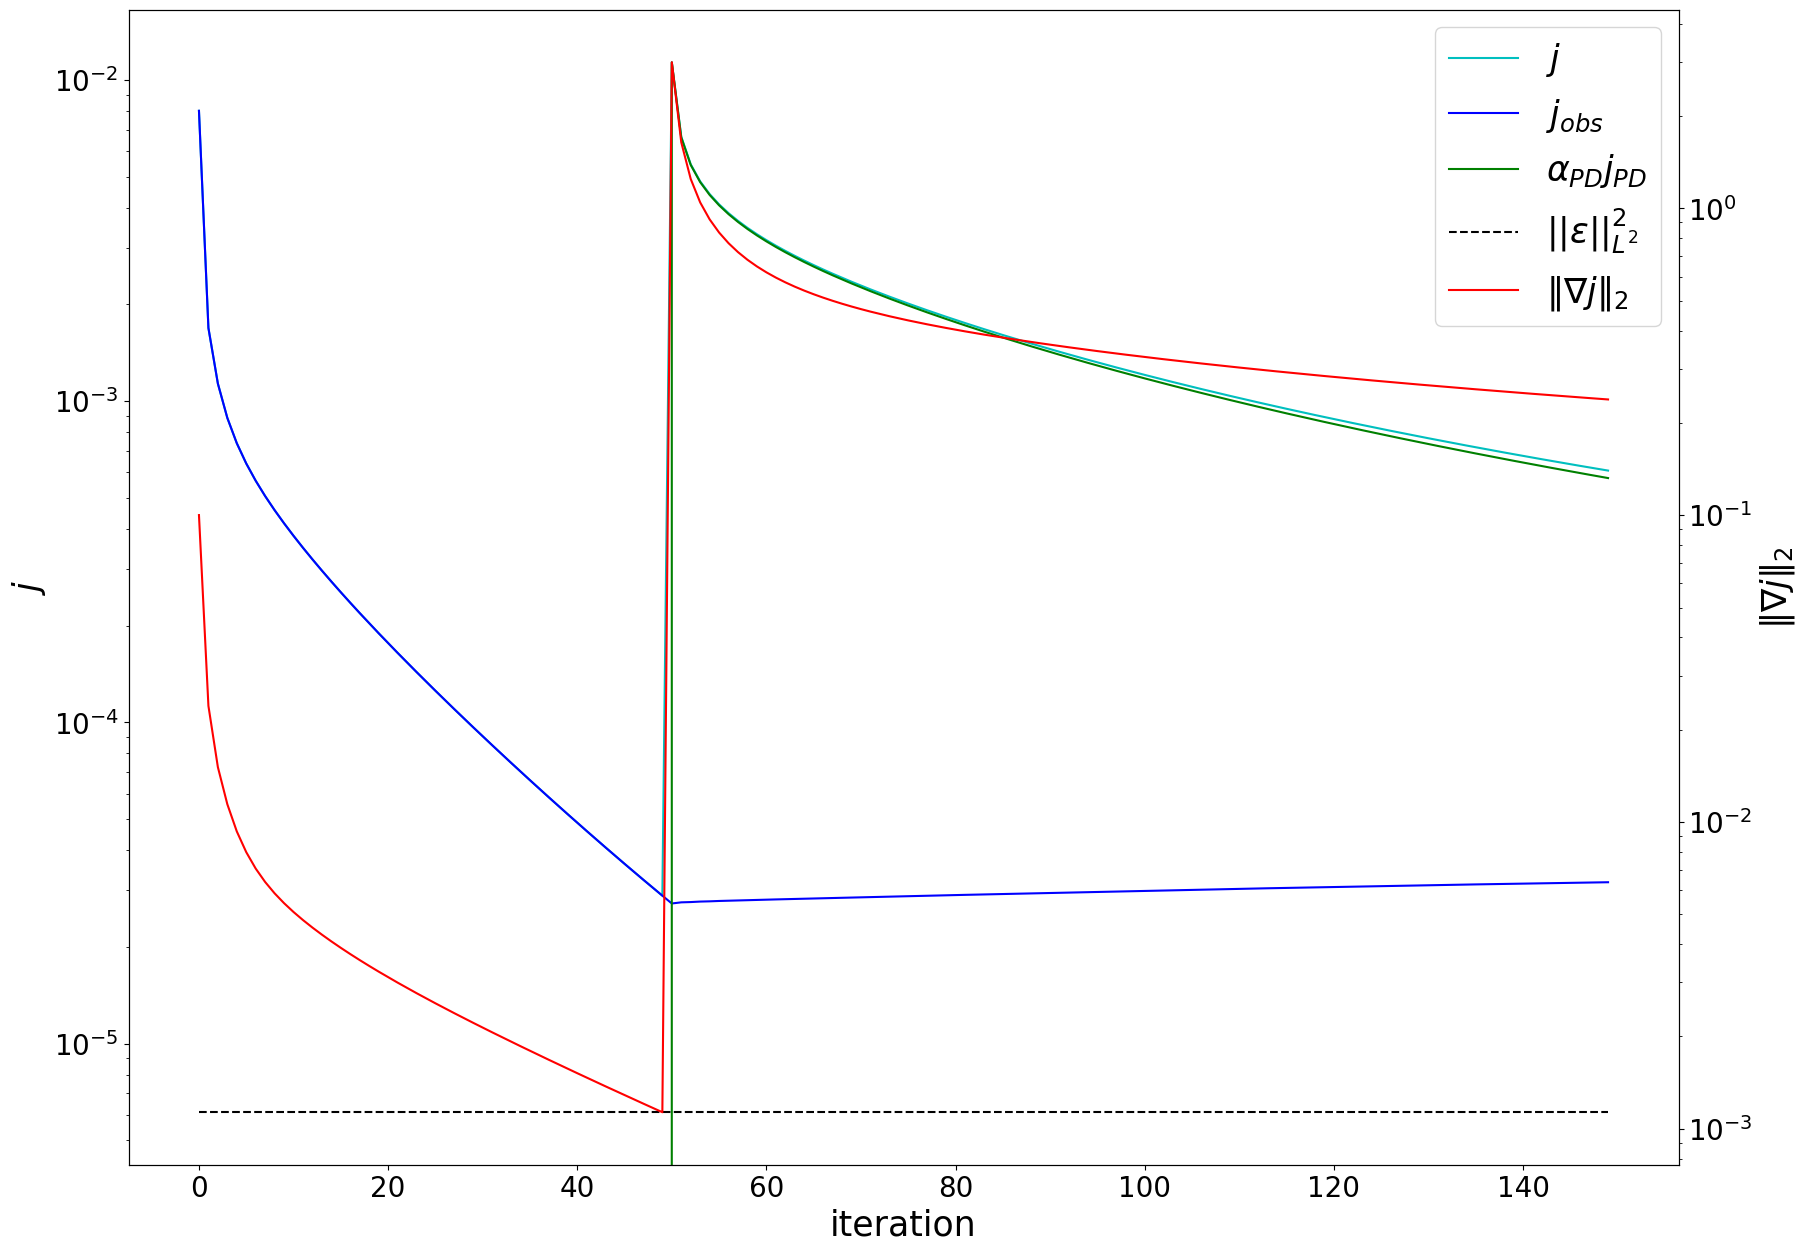

In [32]:
plot_cost(
    j_obs_pop_dyn_reg, 
    j_reg_pop_dyn_reg, 
    noise_level, 
    {'Population dynamic': 'PD'}, 
    {'Population dynamic': 'g'}, 
    grad_j = norm_grad_j_pop_dyn_reg,
    figsize=(20, 15)
)

Let us note that if the optimization is started again and no regularization terms are found in the provided folder, the regularization terms are set to 0.

## Inference with the LASSO regularization term

Now, the inference is illustrated with both the population dynamic-informed and the LASSO regularizations.

In [33]:
cost.add_reg('LASSO',  10 * 1e-4)

In this case, the weight coefficient of the population dynamic-informed regularization term is modified using the `modify_weight_reg` method of the object of the class `Cost`.
This method takes as input the keyword of the regularization term and the new value of the weight coefficient.
If the regularization term was not already considered, then this method acts as the `add_reg` method. If the new weight coefficient is 0, then the regularization term will be removed.

In [34]:
cost.modify_weight_reg("Population dynamic", 2. * 1e-4)

As the cost function is no longer differentiable due to the LASSO regularization term, the user should use a convexe non-differentiable optimization algorithm such as the proximal gradient algorithm. 
This algorithm has been implemented in the [submodule](https://forgemia.inra.fr/pherosensor/pherosensor-toolbox/-/blob/main/src/source_localization/proximal_gradient.py) `proximal_gradient`. This type of algorithm should also be used when the group-LASSO regularization term is used. 

In [35]:
options = {
    "nit_max": 40, 
    "step size": 10 * 1.0e-1
} 

In [36]:
direct_model_LASSO_reg, j_obs_LASSO_reg, j_reg_LASSO_reg, norm_grad_j_LASSO_reg, S_a_LASSO_reg = cost.minimize(
    direct_model,
    adjoint_model,
    "proximal gradient", 
    options=options,
    path_save=path_output,
    restart_flag=True,
    j_obs_threshold = noise_level
)

restarting the optimization process from the data contained in the dir /home/tmalou/Documents/pherosensor/pherosensor-toolbox/tutorials/output
Optimizing using the proximal gradient algorithm 
iteration 151: j = 9.338490e-02, j_obs = 3.181527e-05, ite comp time = 7.046e+00s -
iteration 152: j = 9.281711e-02, j_obs = 3.199154e-05, ite comp time = 7.203e+00s -
iteration 153: j = 9.229196e-02, j_obs = 3.219392e-05, ite comp time = 7.923e+00s -
iteration 154: j = 9.180241e-02, j_obs = 3.242089e-05, ite comp time = 7.389e+00s -
iteration 155: j = 9.134358e-02, j_obs = 3.267094e-05, ite comp time = 7.035e+00s -
iteration 156: j = 9.091152e-02, j_obs = 3.294278e-05, ite comp time = 6.990e+00s -
iteration 157: j = 9.050352e-02, j_obs = 3.323519e-05, ite comp time = 7.067e+00s -
iteration 158: j = 9.011692e-02, j_obs = 3.354718e-05, ite comp time = 6.964e+00s -
iteration 159: j = 8.974959e-02, j_obs = 3.387795e-05, ite comp time = 7.167e+00s -
iteration 160: j = 8.939993e-02, j_obs = 3.422682e-

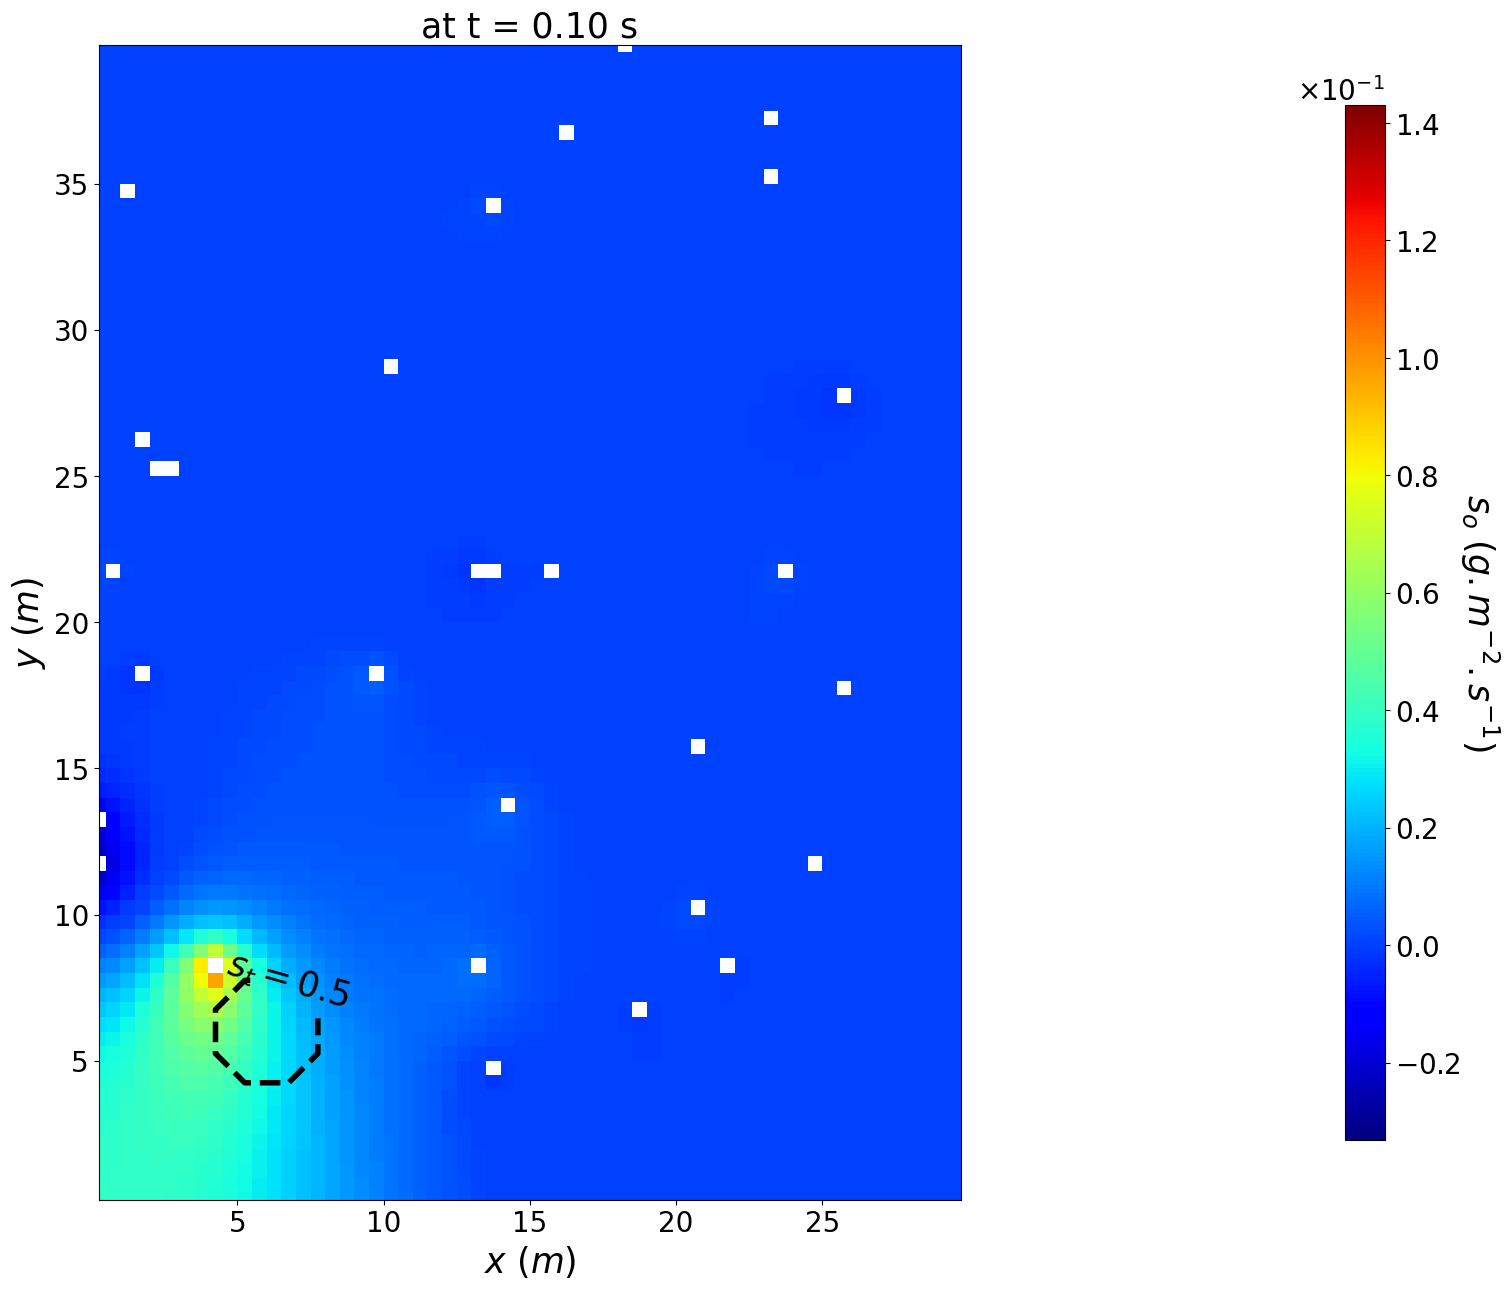

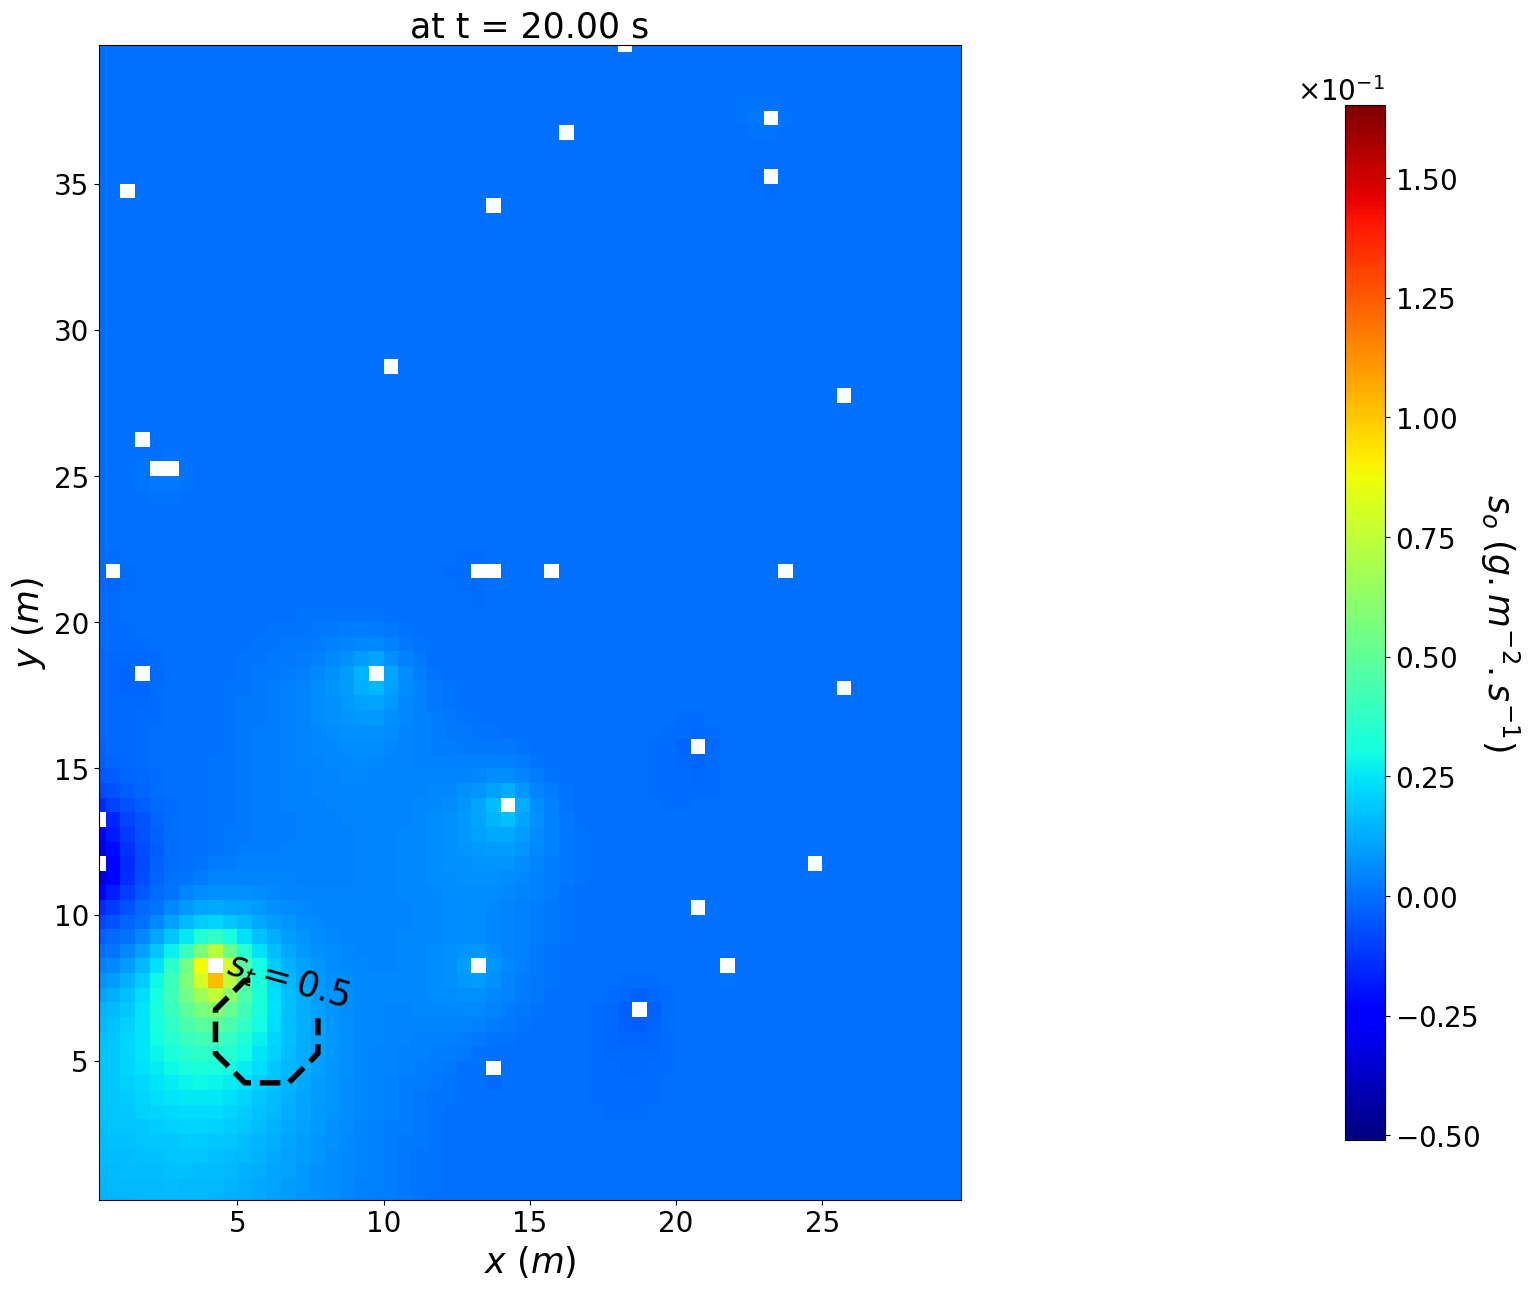

In [37]:
ctrl_LASSO = Control(direct_model_LASSO_reg.S, msh)
ctrl_LASSO.value = ctrl_LASSO.background_value
plot_ctrl(
    msh,
    msh.t_array[1],
    ctrl_LASSO,
    ctrl_target=ctrl_target.value,
    cmap="jet",
    label='s_o',
    obs=cost.obs,
    figsize=(20, 15)
)
plot_ctrl(
    msh,
    msh.t_array[-1],
    ctrl_LASSO,
    ctrl_target=ctrl_target.value,
    cmap="jet",
    label='s_o',
    obs=cost.obs,
    figsize=(20, 15)
)

## Inference with the Tikhonov regularization term

Now, the inference is illustrated with both the population dynamic-informed and the Tikhonov regularizations.

In [38]:
cost.add_reg('Tikhonov',5 * 1e-5)

One can remove a regularization term from the cost function using the `remove_reg` method of the object of the class `Cost`. This method just take the keyword of the regularization term to remove. 

In [39]:
cost.remove_reg("LASSO")

As the LASSO regularization was removed and as the Tikhonov regularization term is differentiable, the cost function is differentiable and thus, the gradient descent algorithm will be used. 

In [40]:
options = {
    "nit_max": 40, 
    "step size": 15 * 1.0e-1
} 

In [41]:
direct_model_Tikhonov_reg, j_obs_Tikhonov_reg, j_reg_Tikhonov_reg, norm_grad_j_Tikhonov_reg, S_a_Tikhonov_reg = cost.minimize(
    direct_model,
    adjoint_model,
    "gradient descent", 
    options=options,
    path_save=path_output,
    restart_flag=True,
    j_obs_threshold = noise_level
)


restarting the optimization process from the data contained in the dir /home/tmalou/Documents/pherosensor/pherosensor-toolbox/tutorials/output
Optimizing using the gradient descent algorithm 
iteration 191: j = 9.693198e-02, j_obs = 5.142371e-05, ite comp time = 3.082e+00s -
iteration 192: j = 9.689534e-02, j_obs = 4.746530e-05, ite comp time = 3.272e+00s -
iteration 193: j = 9.686015e-02, j_obs = 4.431922e-05, ite comp time = 2.871e+00s -
iteration 194: j = 9.682635e-02, j_obs = 4.192340e-05, ite comp time = 3.203e+00s -
iteration 195: j = 9.679384e-02, j_obs = 4.021999e-05, ite comp time = 2.930e+00s -
iteration 196: j = 9.676256e-02, j_obs = 3.915510e-05, ite comp time = 3.221e+00s -
iteration 197: j = 9.673244e-02, j_obs = 3.867849e-05, ite comp time = 3.358e+00s -
iteration 198: j = 9.670342e-02, j_obs = 3.874339e-05, ite comp time = 3.486e+00s -
iteration 199: j = 9.667544e-02, j_obs = 3.930624e-05, ite comp time = 3.502e+00s -
iteration 200: j = 9.664845e-02, j_obs = 4.032645e-0

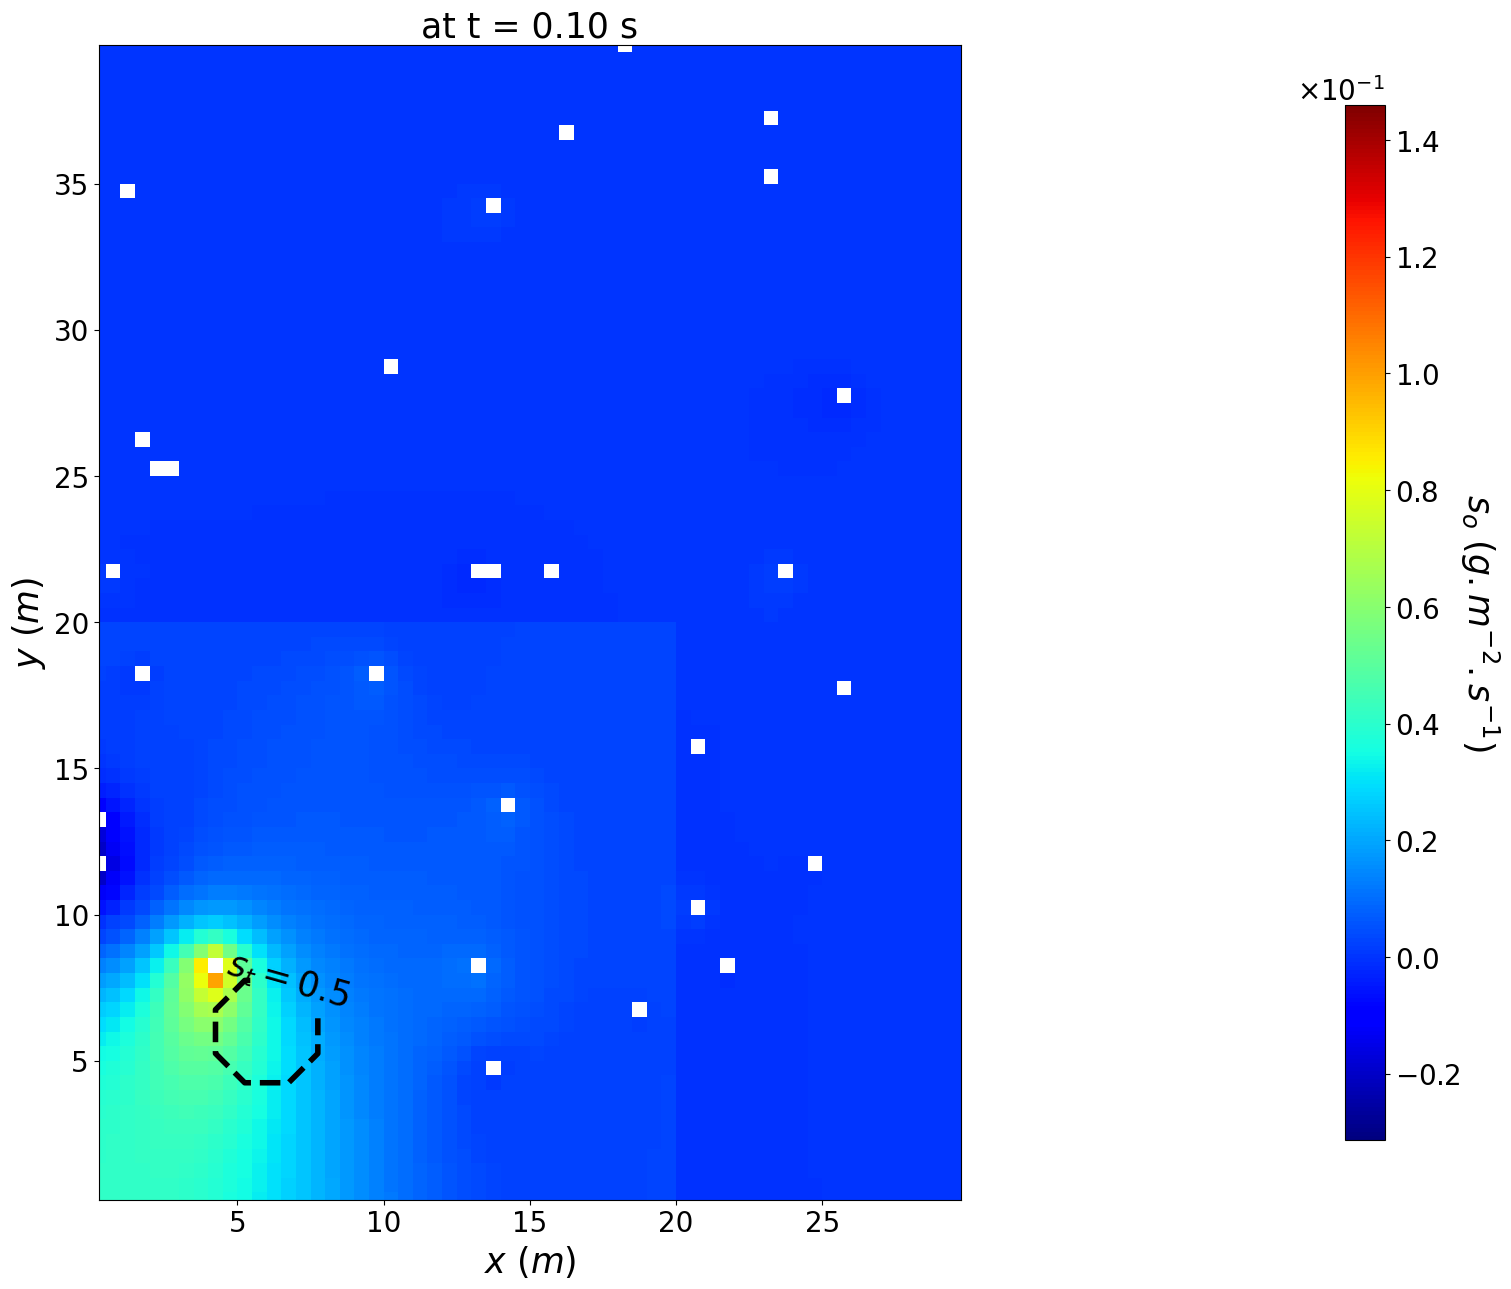

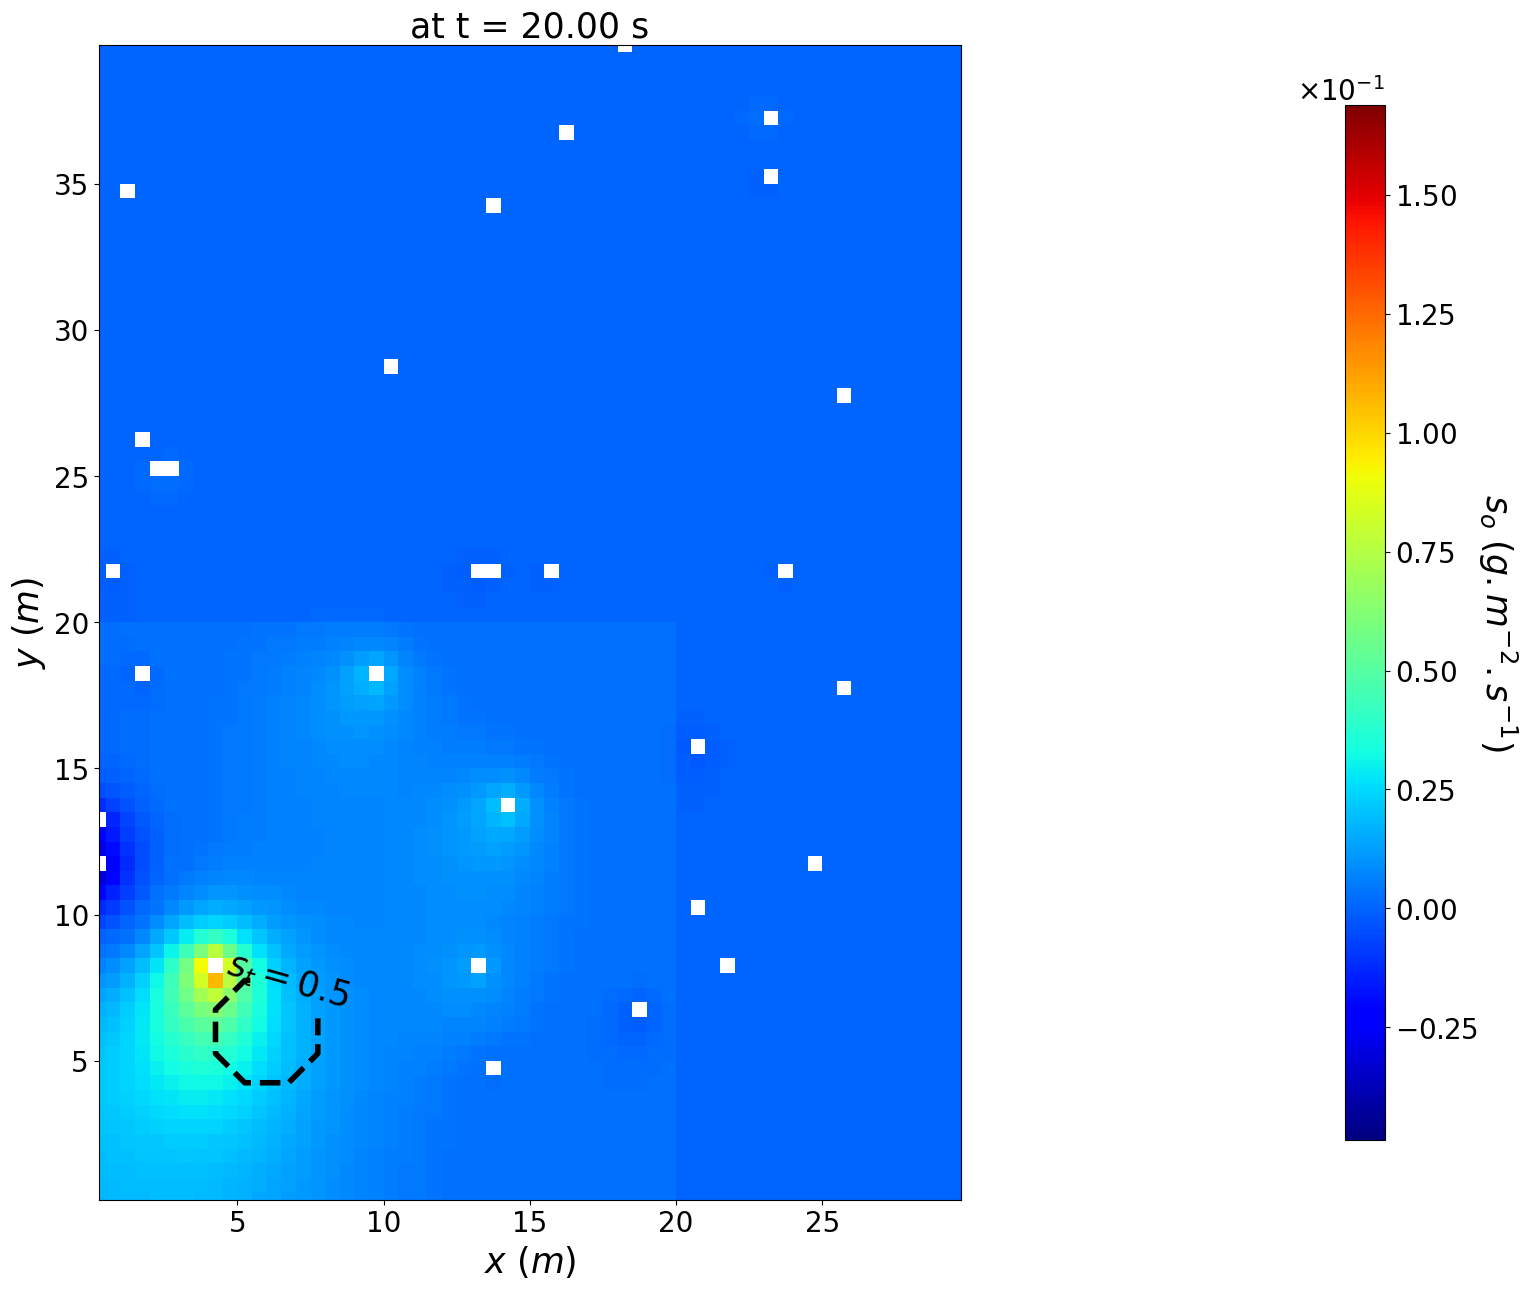

In [42]:
ctrl_Tikhonov = Control(direct_model_Tikhonov_reg.S, msh)
ctrl_Tikhonov.value = ctrl_Tikhonov.background_value
plot_ctrl(
    msh,
    msh.t_array[1],
    ctrl_Tikhonov,
    ctrl_target=ctrl_target.value,
    cmap="jet",
    label='s_o',
    obs=cost.obs,
    figsize=(20, 15)
)
plot_ctrl(
    msh,
    msh.t_array[-1],
    ctrl_Tikhonov,
    ctrl_target=ctrl_target.value,
    cmap="jet",
    label='s_o',
    obs=cost.obs,
    figsize=(20, 15)
)